In [ ]:
import os
import shutil
import random
import time
import itertools
import pickle
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.applications.vgg16 as VGG16
import tensorflow.keras.applications.resnet as ResNet
import tensorflow.keras.applications.inception_v3 as InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAvgPool2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from scipy.spatial.distance import cosine

DRIVE_PATH = 'drive/MyDrive'

def save_pickle(obj, name):
    with open(os.path.join(DRIVE_PATH, name), 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(name):
    with open(os.path.join(DRIVE_PATH, name), 'rb') as f:
        return pickle.load(f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.listdir(DRIVE_PATH)

['IMG_5526_Original.jpeg',
 'IMG_1298.jpeg',
 '20241016194304249_86150.mp3',
 'DSC05675_Original.jpeg',
 'IMG_2254 (1).jpeg',
 'IMG_2467.jpeg',
 'IMG_2595.jpeg',
 'Adobe Scan 2025년 1월 14일.pdf',
 'IMG_2254.jpeg',
 'Colab Notebooks',
 '\x08KTB_week1_simon.gslides',
 'simon.lee(이상원)_생성형AI 2회차_2월.pdf',
 'VGG_validation_features.pkl',
 'VGG_validation_labels.pkl',
 'VGG_train_features.pkl',
 'VGG_train_labels.pkl',
 'VGG_test_features.pkl',
 'VGG_test_labels.pkl',
 '1',
 'history',
 'model',
 'KTB AI 2기 개인 프로젝트 중간 발표_simon.gslides']

# 데이터 가져오기
사용 데이터 : Rice Image Dataset(https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset/data)

In [ ]:
# 데이터 가져오기
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")
shutil.rmtree(path)
path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset")
print("Path to dataset files:", path)

100%|██████████| 219M/219M [00:12<00:00, 18.8MB/s]

Extracting files...


100%|██████████| 219M/219M [00:10<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1


In [ ]:
# path = DRIVE_PATH

In [ ]:
# 데이터셋 경로 설정
print(os.listdir(path))
dataset_path = os.path.join(path, os.listdir(path)[0])
print(dataset_path)

['Rice_Image_Dataset']
/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset


In [ ]:
# 데이터셋 레이블 및 위치 확인
labels = [label for label in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, label))]
print(labels)

label_pathes = [os.path.join(dataset_path, label) for label in labels]
label_images_pathes = [label_path for label_path in label_pathes]
print(label_images_pathes)

['Karacadag', 'Basmati', 'Jasmine', 'Ipsala', 'Arborio']
['/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Karacadag', '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Basmati', '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Jasmine', '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Ipsala', '/root/.cache/kagglehub/datasets/muratkokludataset/rice-image-dataset/versions/1/Rice_Image_Dataset/Arborio']


# 필요한 클래스 정의

## 데이터셋 관련

In [ ]:
# 레이블 별로 데이터셋을 담을 클래스 정의
# 레이블과 Dataset이 있는 폴더의 path를 인자로 주면 자동으로 데이터를 로드
from dataclasses import dataclass, field

@dataclass
class DatasetPerLabel:
    label: str
    path: str

    def __len__(self):
        return len(self.images)

    def load_image_pathes(self):
        self.image_pathes = [os.path.join(self.path, image) for image in os.listdir(self.path)]

    def load_images(self):
        self.images = [load_img(image_path) for image_path in self.image_pathes]

    def __post_init__(self):
        self.load_image_pathes()
        self.load_images()

    def __getitem__(self, index):
        return self.images[index]

    def show_sample(self, count=5):
        fig, ax = plt.subplots(1, count, figsize=(3*count, 3))
        plt.suptitle(f'Samples from Class: {self.label}')
        sample = random.choices(self.images, k=count)
        for i in range(count):
            ax[i].imshow(sample[i])
            ax[i].axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
# 전체 레이블 모두 모아서 관리할 데이터셋 class 정의
@dataclass
class Dataset:
    path: str
    image_size: tuple = (224, 224)

    def __post_init__(self):
        self.labels = [label for label in os.listdir(self.path) if os.path.isdir(os.path.join(self.path, label))]
        self.datasets_per_label = {label : DatasetPerLabel(label, os.path.join(self.path, label)) for label in self.labels}

    def __len__(self):
        return sum(len(dataset) for dataset in self.datsets_per_labels.values())

    def show_sample(self, count=5):
        for dataset in self.datasets_per_label.values():
            dataset.show_sample(count)

    def show_distribution(self):
        labels = self.labels
        counts = tuple(len(dataset) for dataset in self.datasets_per_label.values())
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        plt.suptitle(f'Distributions of Rice')
        color = ['#123456', '#345678', '#56789a', '#789abc', '#9abcde']

        ax[0].set_title('Count')
        ax[0].bar(labels, counts, color=color)

        ax[1].set_title('Percentage')
        ax[1].pie(counts, labels=labels, autopct='%1.1f%%', colors=color)

        plt.show()

    def load(self, batch_size=32, shuffle=False):
        dataset = image_dataset_from_directory(self.path, image_size=self.image_size, batch_size=batch_size, label_mode='categorical').prefetch(tf.data.AUTOTUNE)
        # dataset = image_dataset_from_directory(self.path, image_size=self.image_size, batch_size=batch_size, label_mode='categorical')
        scaled_dataset = dataset.map(lambda x, y: (x / 255, y))
        if shuffle:
            scaled_dataset = scaled_dataset.shuffle(buffer_size=256)
        return scaled_dataset

## 경량화 관련

In [ ]:
class ConvLayer:
    def __init__(self, layer):
        self.layer = layer

    # 전체적인 레이어 구조
    def __repr__(self):
        return self.layer.__repr__()

    # Filter들
    @property
    def filters(self):
        return self.layer.get_weights()[0]

    # Filter 개수
    @property
    def filter_count(self):
        return self.filters.shape[-1]

    # 코사인 유사도를 위한 함수
    ## Flatten된 Filter들 반환(filter 개수,
    @property
    def flattened_filters(self):
        return self.filters.reshape(self.filter_count, -1)

    ## 유사한 Filter쌍 반환
    def find_similar_filter_pair(self, threshold=0.95):
        similar_pair = []
        for i in range(self.filter_count):
            for j in range(i+1, self.filter_count):
                similarity = 1 - cosine(self.flattened_filters[i], self.flattened_filters[j])
                if similarity > threshold:
                    similar_pair.append((i, j, similarity))

        return similar_pair

    ## 코사인 유사성 시각화
    def show_filter_similarity(self):
        sim_matrix = np.zeros((self.filter_count, self.filter_count))
        # print('Start!')
        for i in range(self.filter_count):
            # print(f'------------row {i} start------------')
            for j in range(i, self.filter_count):
                sim_matrix[i, j] = 1 - cosine(self.flattened_filters[i], self.flattened_filters[j])
                sim_matrix[j, i] = sim_matrix[i, j]
                # print(f'col {j} done!')

        plt.figure(figsize=(10, 8))
        plt.imshow(sim_matrix, cmap='gray', interpolation='nearest')
        plt.xlabel('Filter Index')
        plt.ylabel('Filter Index')
        plt.tight_layout()
        plt.show()

        return sim_matrix

    ## 가장 유사한 Filter쌍 반환
    def find_most_similar_filter_pair(self):
        most_similar_pair = (0, 0, -1)
        for i in range(self.filter_count):
            for j in range(i+1, self.filter_count):
                similarity = 1 - cosine(self.flattened_filters[i], self.flattened_filters[j])
                if similarity > most_similar_pair[-1]:
                    most_similar_pair = (i, j, similarity)

        return most_similar_pair

    # L1-Norm 기반 Pruning
    ## 각 필터의 L1-Norm 계산
    @property
    def l1_norm(self):
        if not hasattr(self, '_l1_norm'):
            abs_flattened_filters = np.abs(self.flattened_filters)
            self._l1_norm = np.sum(abs_flattened_filters, axis=1)
        return self._l1_norm

    ## L1-Norm 순으로 Filter Index 반환
    @property
    def l1_norm_argsort(self):
        if not hasattr(self, '_l1_norm_argsort'):
            self._l1_norm_argsort = np.argsort(self.l1_norm)
        return self._l1_norm_argsort

    def l1_norm_filtered_index(self, percentage=0.1):
        count = int(len(self.l1_norm_argsort) * percentage) + 1
        return self.l1_norm_argsort[count:]

    ## L1-Norm 순으로 count만큼 제거한 filter와 bias 반환
    def l1_norm_pruned_weights(self, percentage=0.1):
        pruned_filters = self.filters[:, :, :, self.l1_norm_filtered_index(percentage)]
        pruned_bias = self.get_weights()[1][self.l1_norm_filtered_index(percentage)]
        return [pruned_filters, pruned_bias]

    # 그 외의 접근은 다 layer에게로
    def __getattr__(self, attr):
        return getattr(self.layer, attr)

In [ ]:
class CNNModel:
    def __init__(self, model, include_top=False):
        self.model = model.layers[0] if include_top else model
        self.layers = self.model.layers
        self.conv_layers = [ConvLayer(layer) for layer in self.layers if 'conv' in layer.name]

    def __repr__(self):
        return self.model.summary().__repr__()

    def __len__(self):
        return len(self.layers)

    def __getattr__(self, attr):
        return getattr(self.model, attr)

    # 코사인 유사도
    ## 모든 Conv Layer에서 유사한 필터들을 반환
    def find_similar_filter_pairs(self, threshold=0.95):
        return [layer.find_similar_filter_pair(threshold) for layer in self.conv_layers]

    ## 모든 Conv Layer에서, 유사한 필터의 개수 합을 반환
    def count_similar_filter_pairs(self, threshold=0.95):
        return sum(len(pairs) for pairs in self.find_similar_filter_pairs(threshold))

    ## Conv Layer마다 가장 유사한 Filter Pair 찾기
    def find_most_similar_filter_pairs(self):
        return [layer.find_most_similar_filter_pair() for layer in self.conv_layers]

    # L1-Norm, 학습시킨 Classification Layer 바로 붙여 사용하게 마지막 필터는 Pruning X
    def build_l1_norm_pruned_model(self, percentage=0.1, include_top=False):
        inputs = Input(shape=self.input_shape[-3:])
        x = inputs
        for i, layer in enumerate(self.layers[1:]):
            config = layer.get_config()
            if isinstance(layer, Conv2D):
                config['filters'] = int(config['filters'] * (1 - percentage)) if not (include_top and i >= len(self.layers) - 3) else config['filters']
            new_layer = layer.__class__.from_config(config)
            x = new_layer(x)
        new_model = CNNModel(Model(inputs=inputs, outputs=x))
        for i, (new_layer, layer) in enumerate(zip(new_model.conv_layers, self.conv_layers)):
            new_weights, new_bias = layer.l1_norm_pruned_weights(percentage) if not (include_top and i >= len(self.conv_layers) - 1) else layer.get_weights()
            if i > 0:
                new_weights = new_weights[:, :, filtered_index,:]
            new_layer.set_weights([new_weights, new_bias])
            filtered_index = layer.l1_norm_filtered_index(percentage)
        return new_model

## 훈련 시간 기록

In [ ]:
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

# 필요한 함수 정의

## 데이터셋 관련

In [ ]:
# 이미지 데이터를 분할하여 각각 test(70%) / val(15%) / test(15%) directory에 저장
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    random.seed(42)
    for label, dataset_per_label in dataset.datasets_per_label.items():
        image_pathes = dataset_per_label.image_pathes
        random.shuffle(image_pathes)
        total = len(image_pathes)
        train_size = int(total * train_ratio)
        val_size = int(total * val_ratio)

        split = {
            'train': image_pathes[:train_size],
            'val': image_pathes[train_size:train_size+val_size],
            'test': image_pathes[train_size+val_size:]
        }

        for split_name, split_pathes in split.items():
            split_dir = os.path.join(dataset_path, split_name, label)
            os.makedirs(split_dir, exist_ok=True)

            for path in split_pathes:
                shutil.copy2(path, split_dir)

## 모델 관련

In [ ]:
# 사전 학습된 VGG 모델을 생성.
def build_vgg_model(global_avg_pool: bool, trainable=False):
    base_model = VGG16.VGG16(weights='imagenet', include_top=False, input_shape=(*dataset.image_size, 3))
    base_model.trainable = trainable
    model = Sequential([
        base_model,
        GlobalAvgPool2D() if global_avg_pool else Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])
    adam = Adam(learning_rate=0.00001 if trainable else 0.001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# 학습 history 시각화
def visualize_history(historys, names=['']):
    # 그래프 생성
    plt.figure(figsize=(12, 5))
    if type(historys) != list:
        historys = [historys]

    for history, name in zip(historys, names):
        # 성능 지표 추출
        accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        # 정확도 그래프
        plt.subplot(1, 2, 1)
        plt.plot(accuracy, label=f'{name} Train Accuracy')
        plt.plot(val_accuracy, label=f'{name} Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # 손실 그래프
        plt.subplot(1, 2, 2)
        plt.plot(loss, label=f'{name} Train Loss')
        plt.plot(val_loss, label=f'{name} Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

    plt.show()

In [ ]:
# 학습 후 학습 history, checkpoint를 불러와 모델 weights 등을 저장하고 평가를 진행하는 함수
def after_train(model, model_name, history, time_callback, db_path='training.db'):
    os.makedirs(os.path.join(DRIVE_PATH, 'history'), exist_ok=True)
    os.makedirs(os.path.join(DRIVE_PATH, 'model'), exist_ok=True)
    model.load_weights(f'best_{model_name}.weights.h5')
    save_pickle(history, os.path.join('history', f'{model_name}_history'))
    model.save(os.path.join(DRIVE_PATH, 'model', f'{model_name}.keras'))
    loss, accuracy = model.evaluate(test_data)

    def save_training_log_to_sqlite(
    time_callback,
    model_name: str,
    pruning_ratio: float,
    test_accuracy: float,
    db_path: str = "experiments.db"
):
    # DB 연결
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()

    # 테이블 없으면 생성
    cur.execute('''
        CREATE TABLE IF NOT EXISTS training_logs (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            model TEXT,
            epoch_times TEXT,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        )
    ''')

    # 데이터 삽입
    cur.execute('''
        INSERT INTO training_logs (model, epoch_times)
        VALUES (?, ?)
    ''', (
        model_name,
        json.dumps(time_callback.times)  # 리스트를 문자열로 저장
    ))

    conn.commit()
    conn.close()
    return loss, accuracy

In [ ]:
# 저장된 모델을 불러오는 함수
def load_model(model_name):
    return tf.keras.models.load_model(os.path.join(DRIVE_PATH, 'model', f'{model_name}.keras'))

## Feature Map 시각화 관련

In [ ]:
# 시각화 함수 정의
def visualize_feature_maps(feature_maps, channel_limit=None):
    num_channels = min(feature_maps.shape[-1], channel_limit) if channel_limit else feature_maps.shape[-1]
    cols = 5
    rows = int(num_channels / cols) + 1
    plt.figure(figsize=(3 * cols, 3 * rows))
    for i in range(num_channels):
        plt.subplot(rows, cols, i+1)
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
        plt.axis('off')
        plt.title(f'{i}')
    plt.tight_layout()
    plt.show()

# Model에서 conv_num번째(None이면 전체) Feature Maps을 출력하는 모델을 반환
def build_feature_model(model, conv_num=None):
    feature_layer = model.layers[0]
    layer_outputs = [layer.output for layer in feature_layer.layers if 'conv' in layer.name]
    outputs = [layer_outputs[conv_num]] if conv_num else layer_outputs
    return Model(inputs=feature_layer.input, outputs=outputs)

# img_tensor를 입력하면 모든 Feature Map을 출력
def extract_feature_maps(model, img_tensor, conv_num=None):
    feature_model = build_feature_model(model, conv_num)
    feature_maps = feature_model.predict(img_tensor)
    return feature_maps

# 데이터셋 확인

In [ ]:
# (key : label / value : 데이터셋)을 담은 딕셔너리 생성
dataset = Dataset(dataset_path)

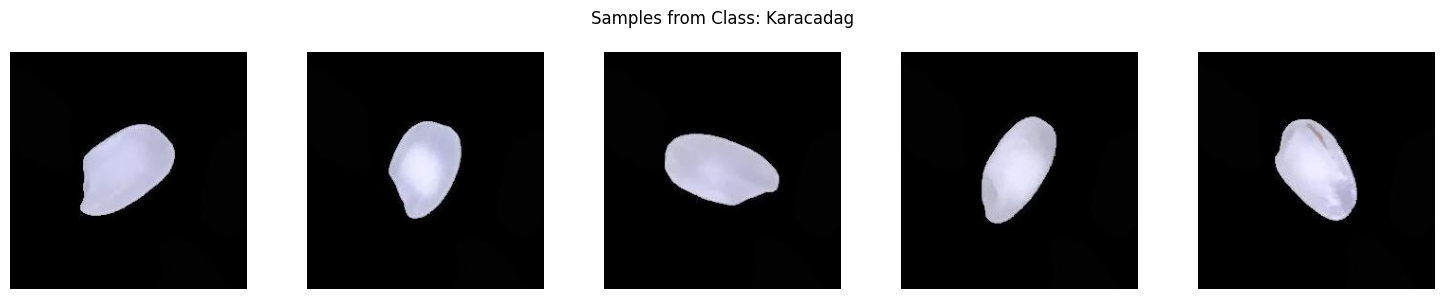

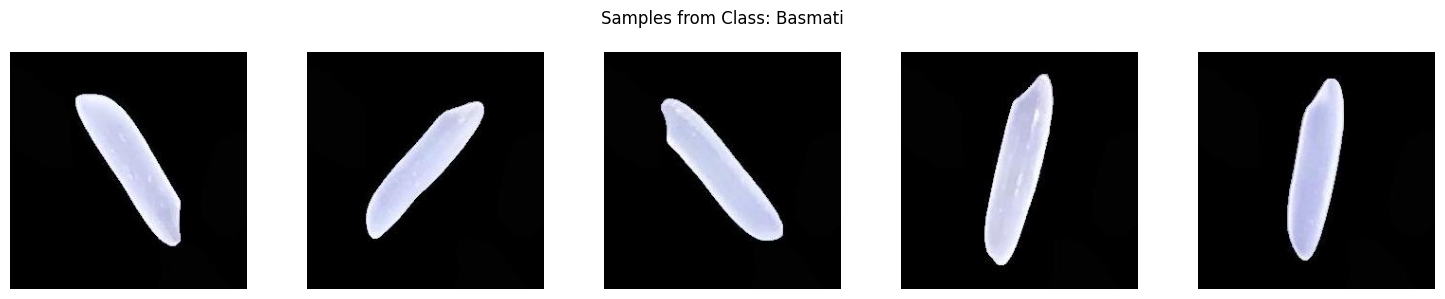

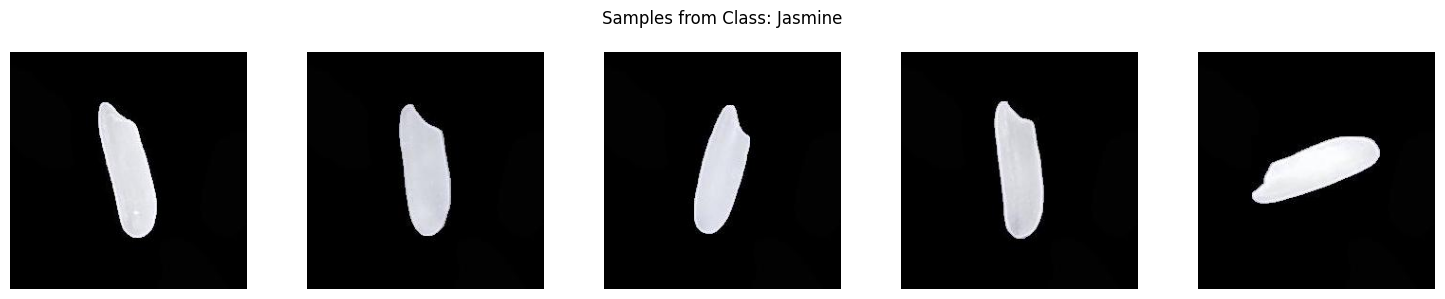

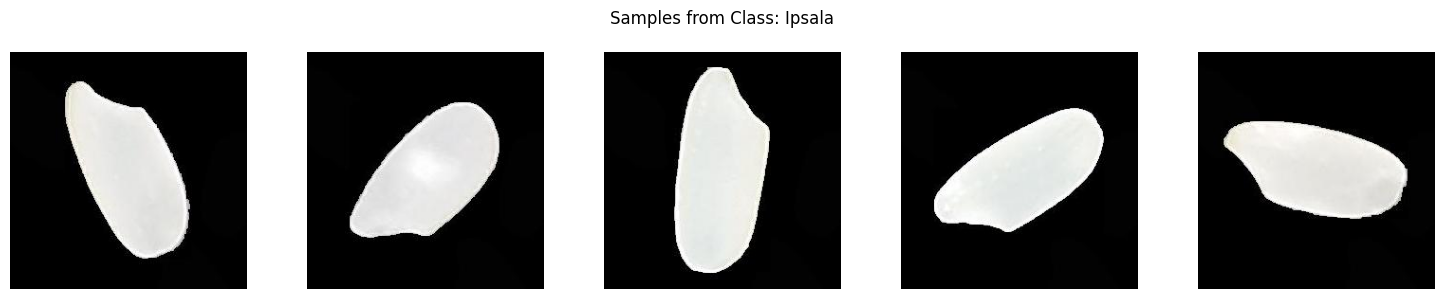

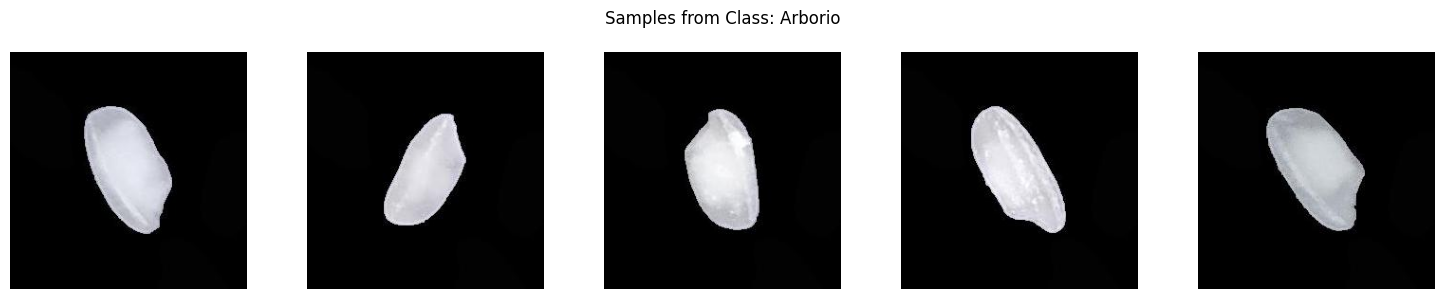

In [ ]:
# 각 품종별 샘플 이미지 출력
dataset.show_sample()

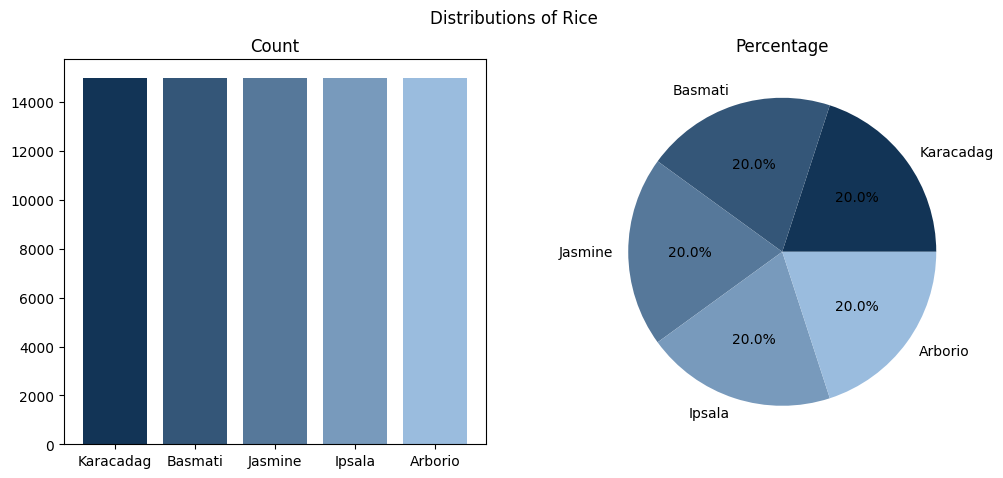

In [ ]:
# 각 품종별 데이터 개수 파악
dataset.show_distribution()

# 모델 훈련 및 검증용 데이터셋 준비

In [ ]:
split_dataset(dataset)

In [ ]:
os.listdir(dataset_path)

['test',
 'train',
 'Rice_Citation_Request.txt',
 'Karacadag',
 'Basmati',
 'Jasmine',
 'Ipsala',
 'Arborio',
 'val']

In [ ]:
# 각 자료의 경로 지정
train_path = os.path.join(dataset_path, 'train')
val_path = os.path.join(dataset_path, 'val')
test_path = os.path.join(dataset_path, 'test')

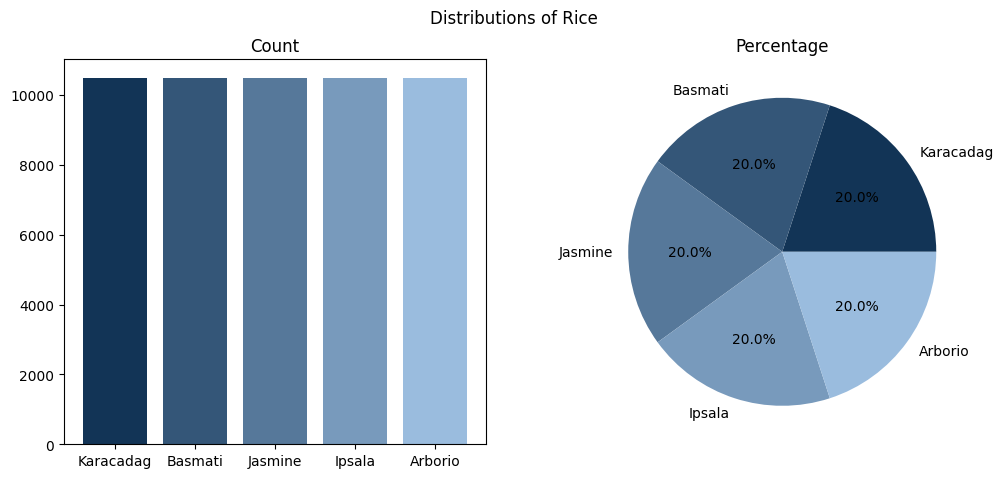

In [ ]:
# 고르게 잘 분리되었는지 확인
train_dataset = Dataset(train_path)
train_dataset.show_distribution()

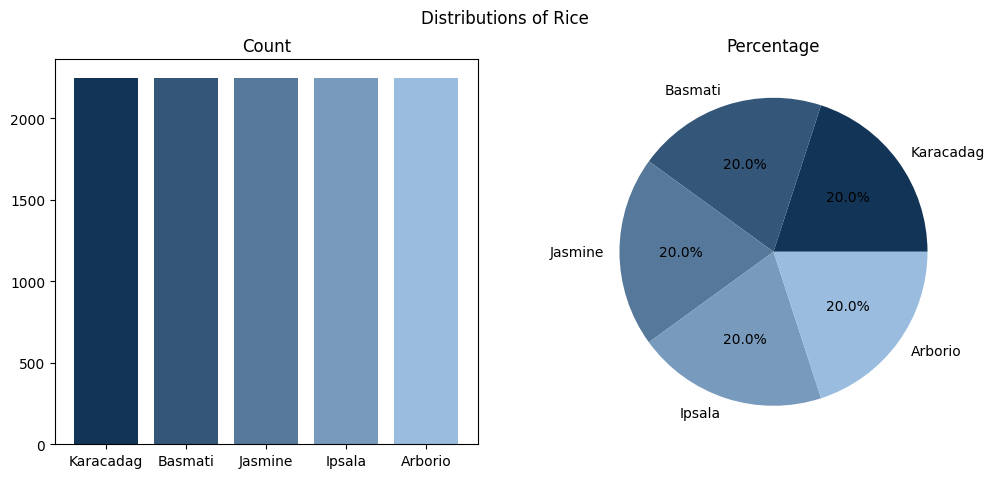

In [ ]:
val_dataset = Dataset(val_path)
val_dataset.show_distribution()

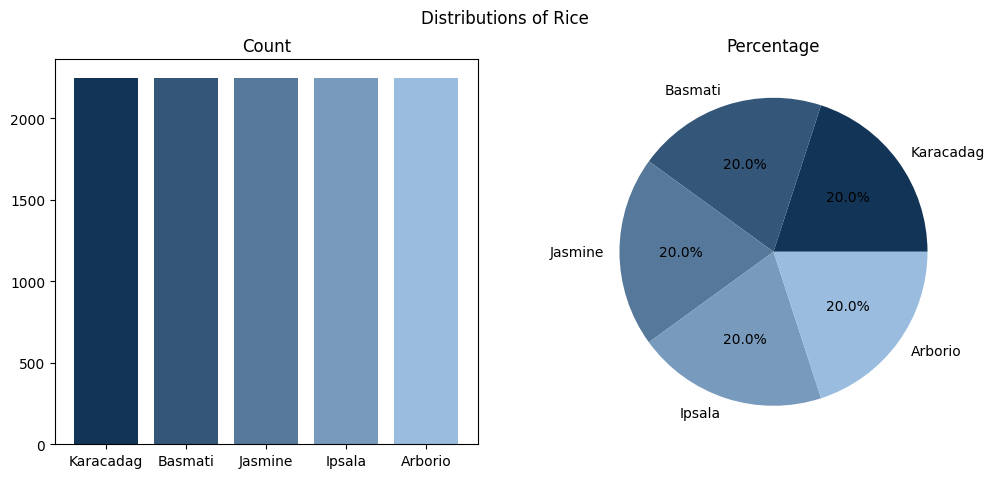

In [ ]:
test_dataset = Dataset(test_path)
test_dataset.show_distribution()

In [ ]:
train_data = train_dataset.load(batch_size=16, shuffle=True)
val_data = val_dataset.load(batch_size=16)
test_data = test_dataset.load(batch_size=16)

Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


# 모델 생성 및 학습

In [ ]:
# 비교를 위해 동일하게 유지하는 부분
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_delta=0.001, min_lr = 1e-5)
checkpoint = ModelCheckpoint('best_model.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)

## VGG16

### Feature Extraction
- Feature Layer는 학습하지 않고 Classification Layer만 학습

In [ ]:
# VGG16의 Feature Layer 살펴보기
VGG_feature_layer = VGG16.VGG16(weights='imagenet', include_top=False, input_shape=(*dataset.image_size, 3))
VGG_feature_layer.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

- 두 가지 방식을 다르게 학습
    1. Feature Layer를 거친 후 GlobalAvgPool2D or Flatten

In [ ]:
VGG_Global = build_vgg_model(True)
VGG_Flatten = build_vgg_model(False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
checkpoint = ModelCheckpoint('best_VGG_Global.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
VGG_Global_history = VGG_Global.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.8621 - loss: 0.4114 - val_accuracy: 0.9863 - val_loss: 0.0463 - learning_rate: 0.0010
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9740 - loss: 0.0797 - val_accuracy: 0.9874 - val_loss: 0.0383 - learning_rate: 0.0010
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9792 - loss: 0.0633 - val_accuracy: 0.9919 - val_loss: 0.0258 - learning_rate: 0.0010
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9823 - loss: 0.0537 - val_accuracy: 0.9897 - val_loss: 0.0296 - learning_rate: 0.0010
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9834 - loss: 0.0502 - val_accuracy: 0.9932 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accuracy: 0.9852 - loss: 0.0458 - val_accuracy: 0.9930 - val_loss: 0.0232 - learning_rate: 0.0010
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - accura

In [ ]:
VGG_Global_test = after_train(VGG_Global, 'VGG_Global', VGG_Global_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9954 - loss: 0.0161


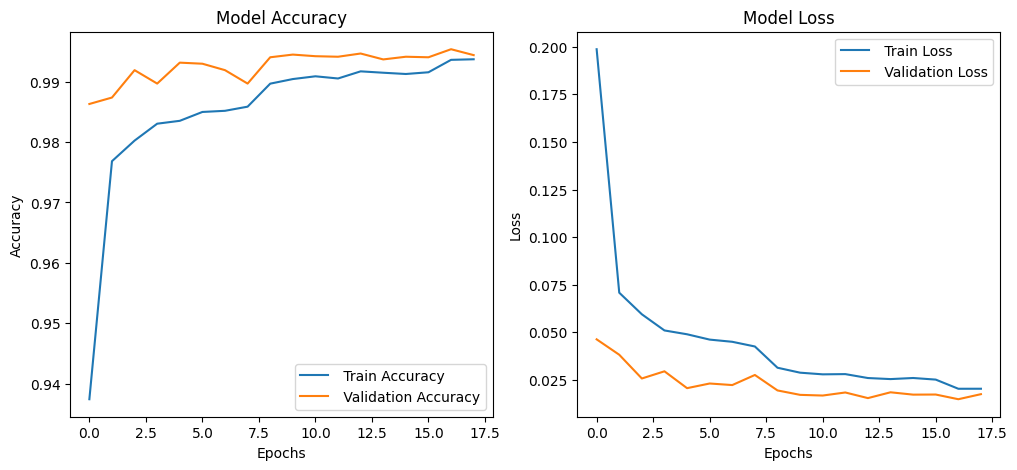

In [ ]:
visualize_history(VGG_Global_history)

In [ ]:
checkpoint = ModelCheckpoint('best_VGG_Flatten.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
VGG_Flatten_history = VGG_Flatten.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.8721 - loss: 0.3770 - val_accuracy: 0.9860 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9334 - loss: 0.1712 - val_accuracy: 0.9871 - val_loss: 0.0405 - learning_rate: 0.0010
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9427 - loss: 0.1561 - val_accuracy: 0.9908 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9498 - loss: 0.1422 - val_accuracy: 0.9913 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9528 - loss: 0.1358 - val_accuracy: 0.9920 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.9564 - loss: 0.1215 - val_accuracy: 0.9896 - val_loss: 0.0365 - learning_rate: 0.0010
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accura

In [ ]:
VGG_Flatten_test = after_train(VGG_Flatten, 'VGG_Flatten', VGG_Flatten_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9954 - loss: 0.0163


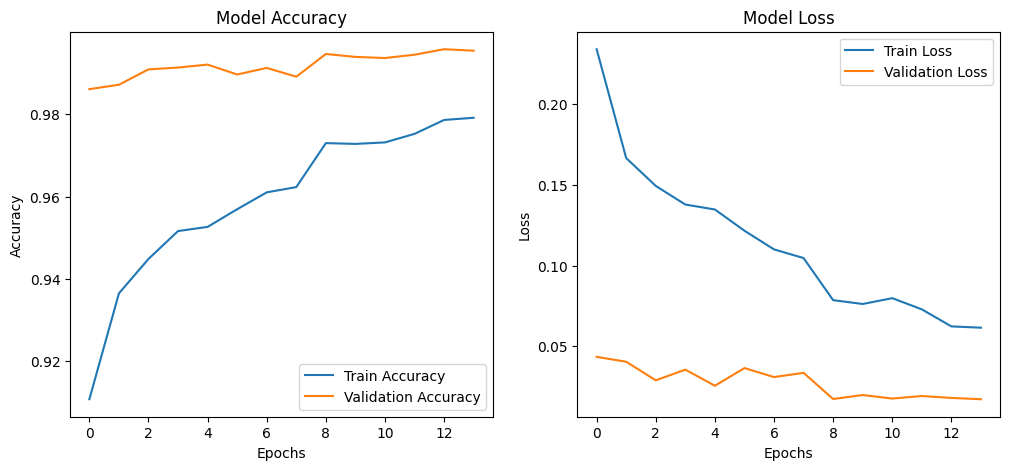

In [ ]:
visualize_history(VGG_Flatten_history)

### Fine-Tuning

In [ ]:
finetuned_VGG_Global = build_vgg_model(True, trainable=True)
finetuned_VGG_Flatten = build_vgg_model(False, trainable=True)

In [ ]:
checkpoint = ModelCheckpoint('best_finetuned_VGG_Global.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
finetuned_VGG_Global_history = finetuned_VGG_Global.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 119s 34ms/step - accuracy: 0.9082 - loss: 0.2269 - val_accuracy: 0.9967 - val_loss: 0.0111 - learning_rate: 1.0000e-05
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9965 - loss: 0.0122 - val_accuracy: 0.9994 - val_loss: 0.0025 - learning_rate: 1.0000e-05
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9972 - loss: 0.0092 - val_accuracy: 0.9989 - val_loss: 0.0031 - learning_rate: 1.0000e-05
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9981 - loss: 0.0064 - val_accuracy: 0.9994 - val_loss: 0.0022 - learning_rate: 1.0000e-05
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9983 - loss: 0.0056 - val_accuracy: 0.9980 - val_loss: 0.0056 - learning_rate: 1.0000e-05
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9988 - val_loss: 0.0042 - learning_rate: 1.0000e-05
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━

In [ ]:
after_train(finetuned_VGG_Global, 'finetuned_VGG_Global', finetuned_VGG_Global_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9958 - loss: 0.0153


(0.016405778005719185, 0.9957333207130432)

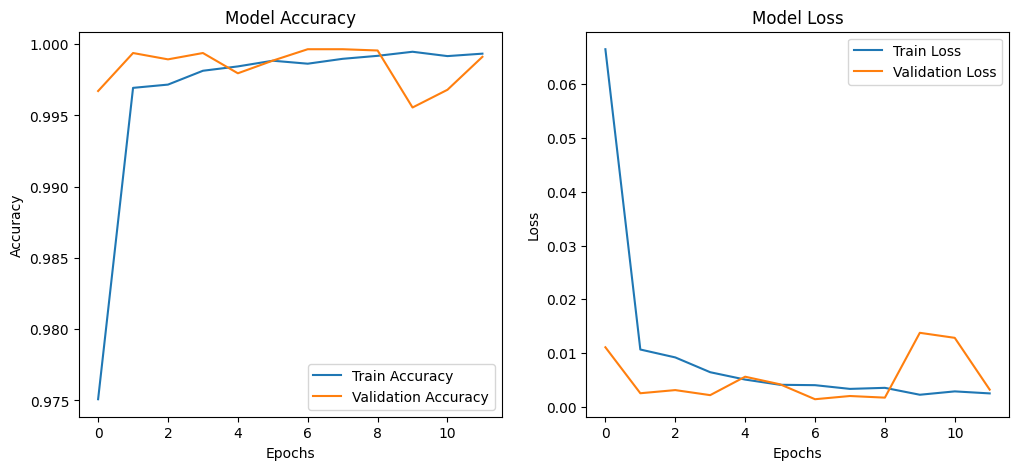

In [ ]:
visualize_history(finetuned_VGG_Global_history)

In [ ]:
checkpoint = ModelCheckpoint('best_finetuned_VGG_Flatten.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
finetuned_VGG_Flatten_history = finetuned_VGG_Flatten.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 119s 34ms/step - accuracy: 0.9391 - loss: 0.1558 - val_accuracy: 0.9986 - val_loss: 0.0040 - learning_rate: 1.0000e-05
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9968 - loss: 0.0091 - val_accuracy: 0.9985 - val_loss: 0.0041 - learning_rate: 1.0000e-05
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 108s 33ms/step - accuracy: 0.9983 - loss: 0.0065 - val_accuracy: 0.9991 - val_loss: 0.0031 - learning_rate: 1.0000e-05
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 32ms/step - accuracy: 0.9982 - loss: 0.0065 - val_accuracy: 0.9988 - val_loss: 0.0045 - learning_rate: 1.0000e-05
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 108s 33ms/step - accuracy: 0.9985 - loss: 0.0051 - val_accuracy: 0.9994 - val_loss: 0.0022 - learning_rate: 1.0000e-05
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 107s 33ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9985 - val_loss: 0.0055 - learning_rate: 1.0000e-05
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━

In [ ]:
finetuned_VGG_Flatten_test = after_train(finetuned_VGG_Flatten, 'finetuned_VGG_Flatten', finetuned_VGG_Flatten_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9956 - loss: 0.0159


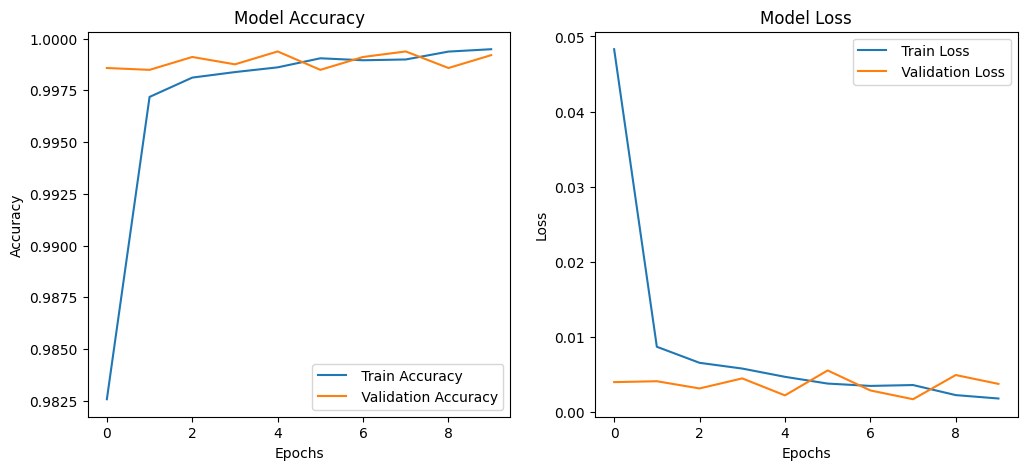

In [ ]:
visualize_history(finetuned_VGG_Flatten_history)

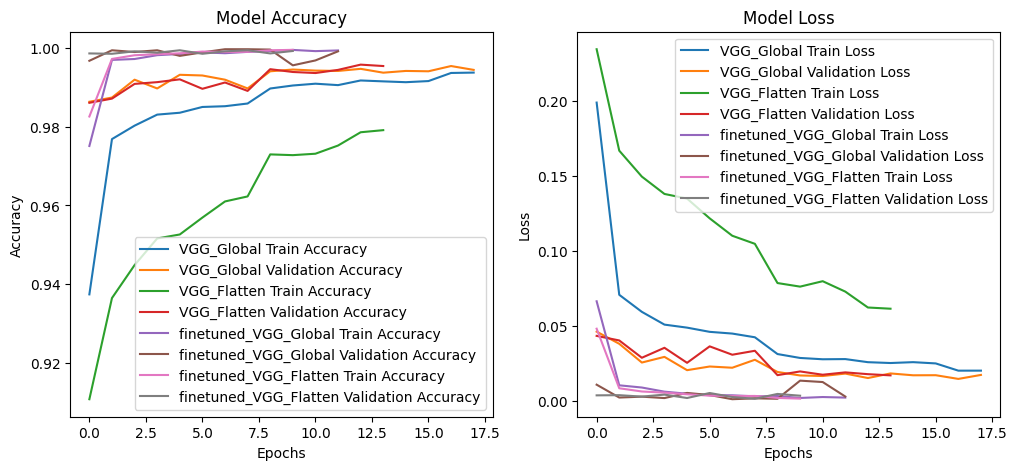

In [ ]:
visualize_history([VGG_Global_history, VGG_Flatten_history, finetuned_VGG_Global_history, finetuned_VGG_Flatten_history], ['VGG_Global', 'VGG_Flatten', 'finetuned_VGG_Global', 'finetuned_VGG_Flatten'])

# 모델 경량화 방안 모색

## 모델 가져오기

In [ ]:
VGG_Global = load_model('VGG_Global')
VGG_Flatten = load_model('VGG_Flatten')
finetuned_VGG_Global = load_model('finetuned_VGG_Global')
finetuned_VGG_Flatten = load_model('finetuned_VGG_Flatten')

## 각 VGG 모델 별 Feature Map 시각화

In [ ]:
# 사용할 데이터 하나 추출
images, _ = next(iter(train_data))
images.shape

TensorShape([16, 224, 224, 3])

In [ ]:
img_tensor = images[:1]
img_tensor.shape

TensorShape([1, 224, 224, 3])

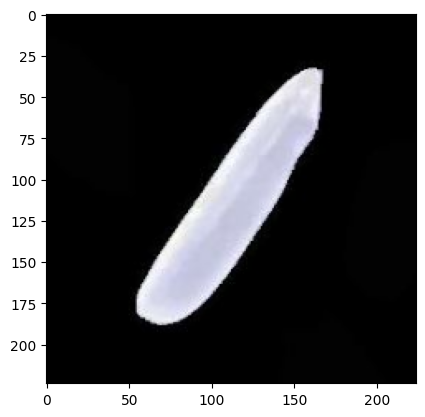

In [ ]:
# 타겟 데이터
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
# VGG에 사용하기 위해 preprocessing
img_tensor = VGG16.preprocess_input(img_tensor)

In [ ]:
feature_layer = VGG_Global.layers[0]
layer_outputs = [layer.output for layer in feature_layer.layers if 'conv' in layer.name]
feature_layer.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


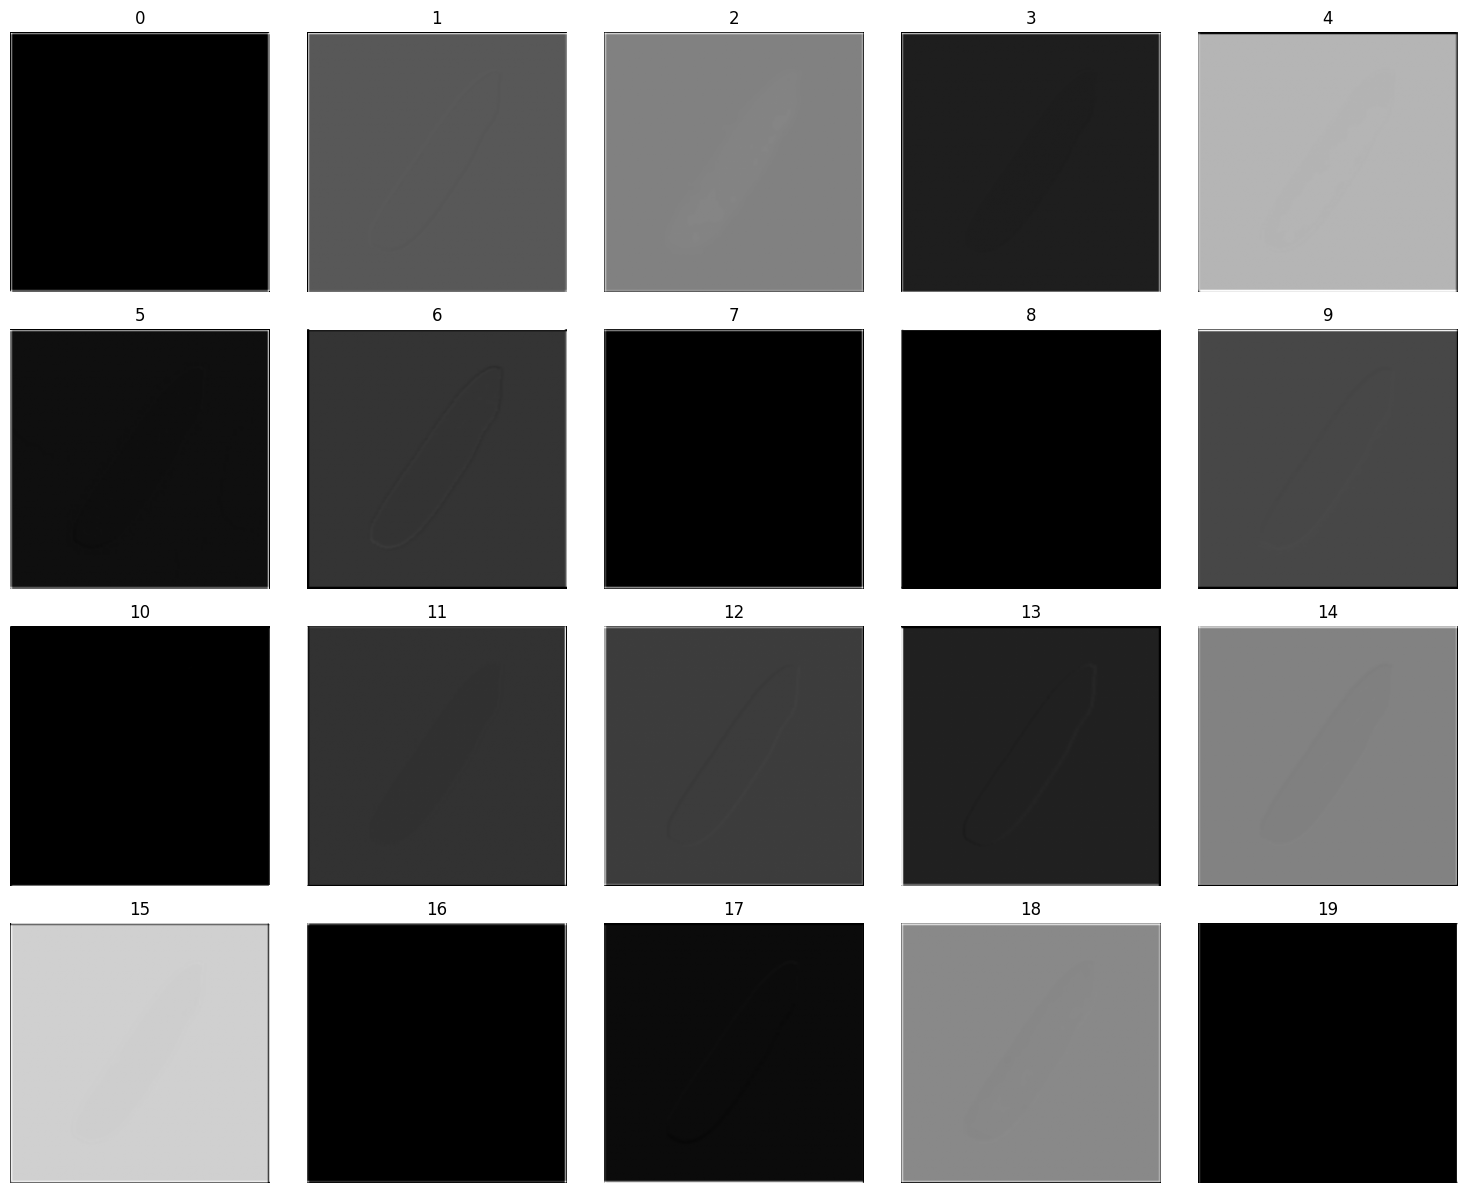

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


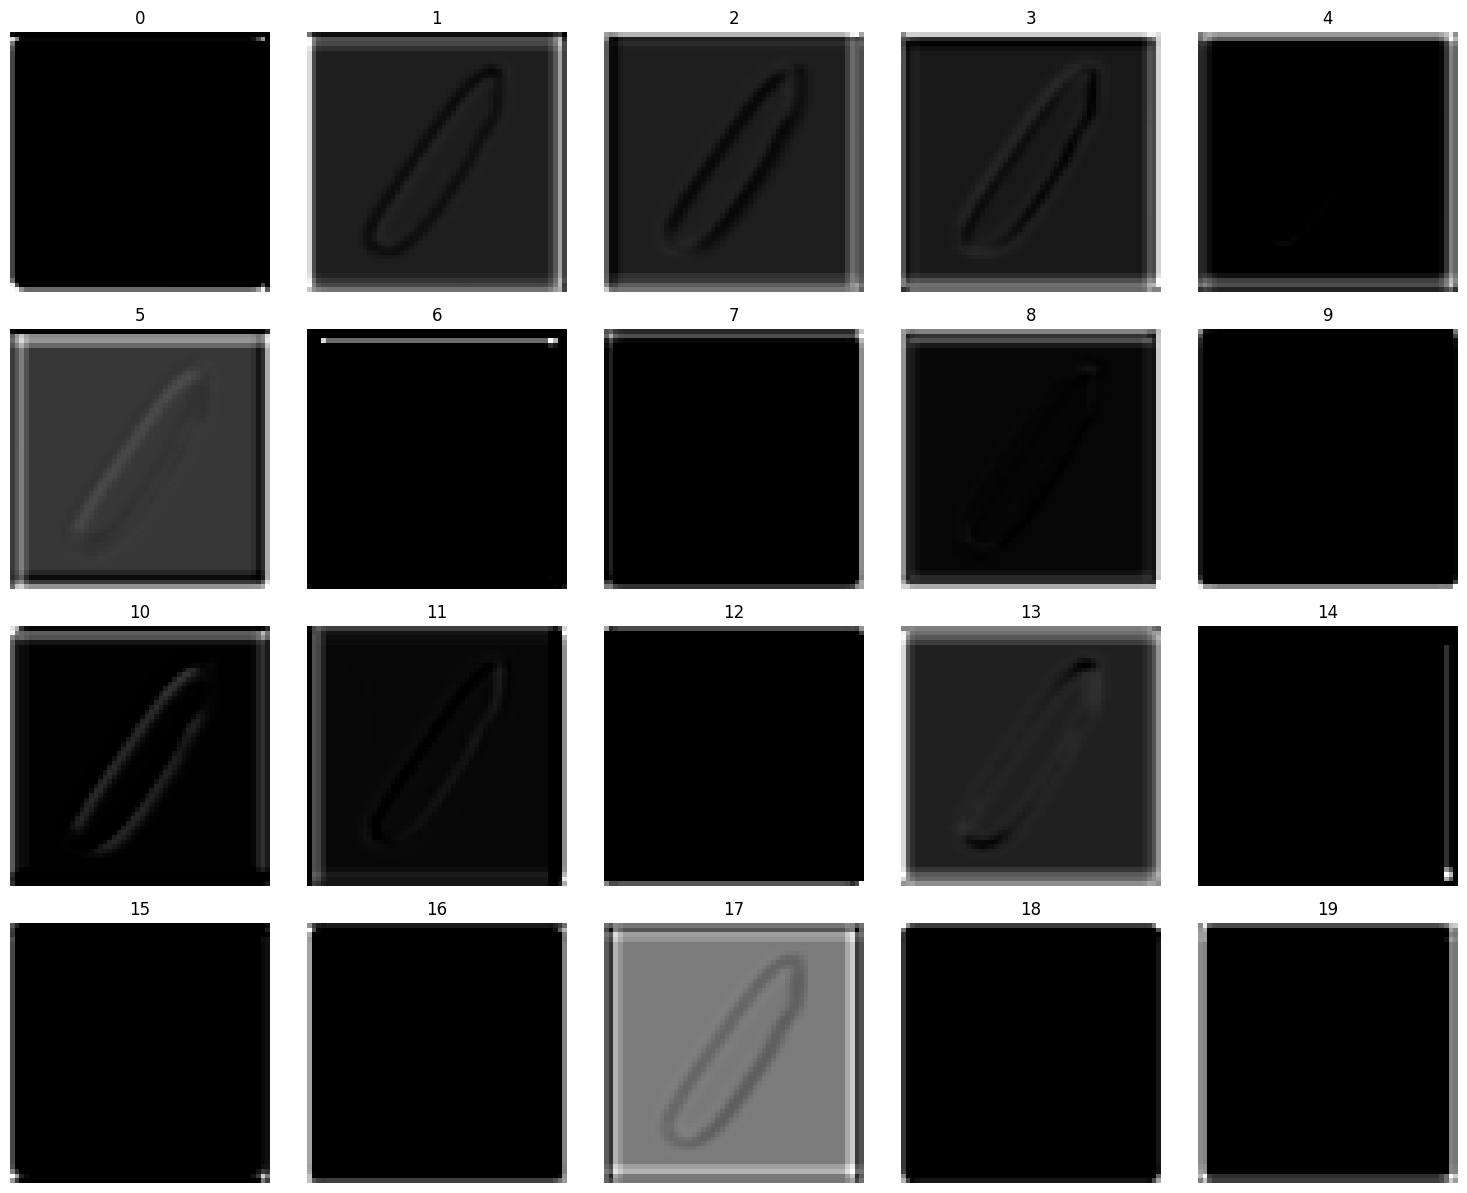

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


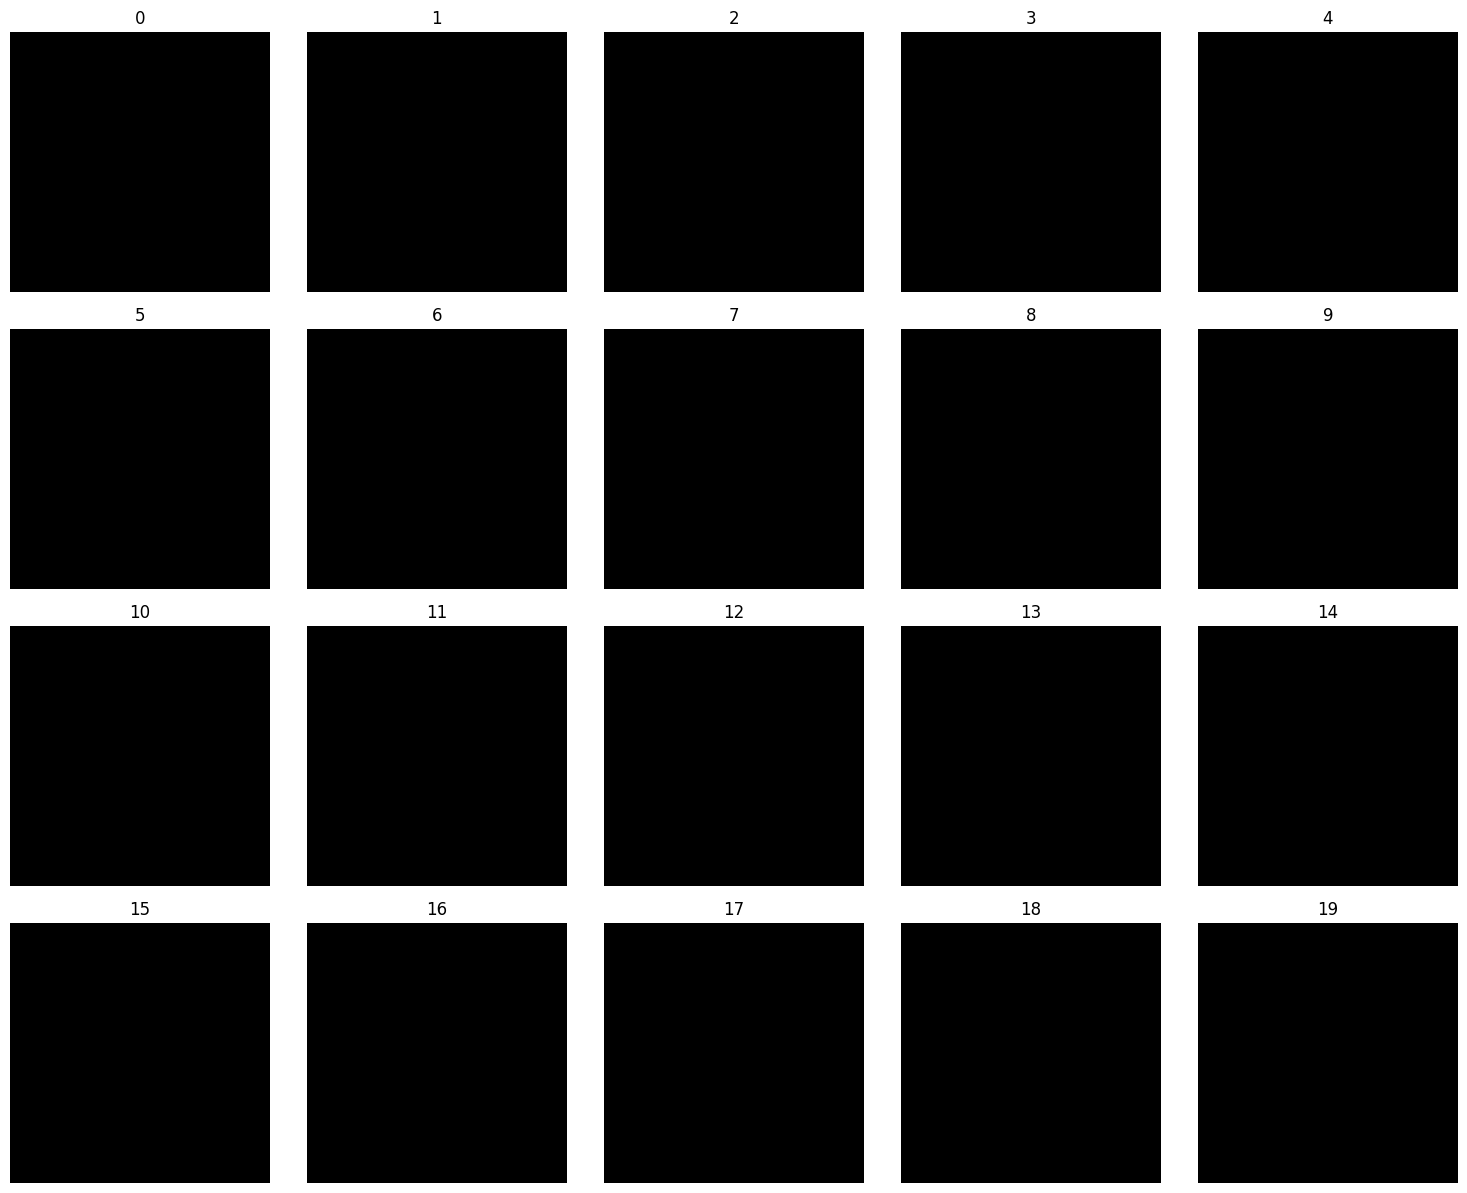

In [ ]:
# 첫번째 Convolution Layer를 통과한 Feature map
visualize_feature_maps(extract_feature_maps(VGG_Global, img_tensor, 1), 20)
# VGG_Global 모델의 6번째(인덱스 5) Convolution Layer의 출력 Feature Map(10개)
visualize_feature_maps(extract_feature_maps(VGG_Global, img_tensor, 5), 20)
# VGG_Global 13번째(마지막) -> 비슷한게 많다.
visualize_feature_maps(extract_feature_maps(VGG_Global, img_tensor, 12), 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


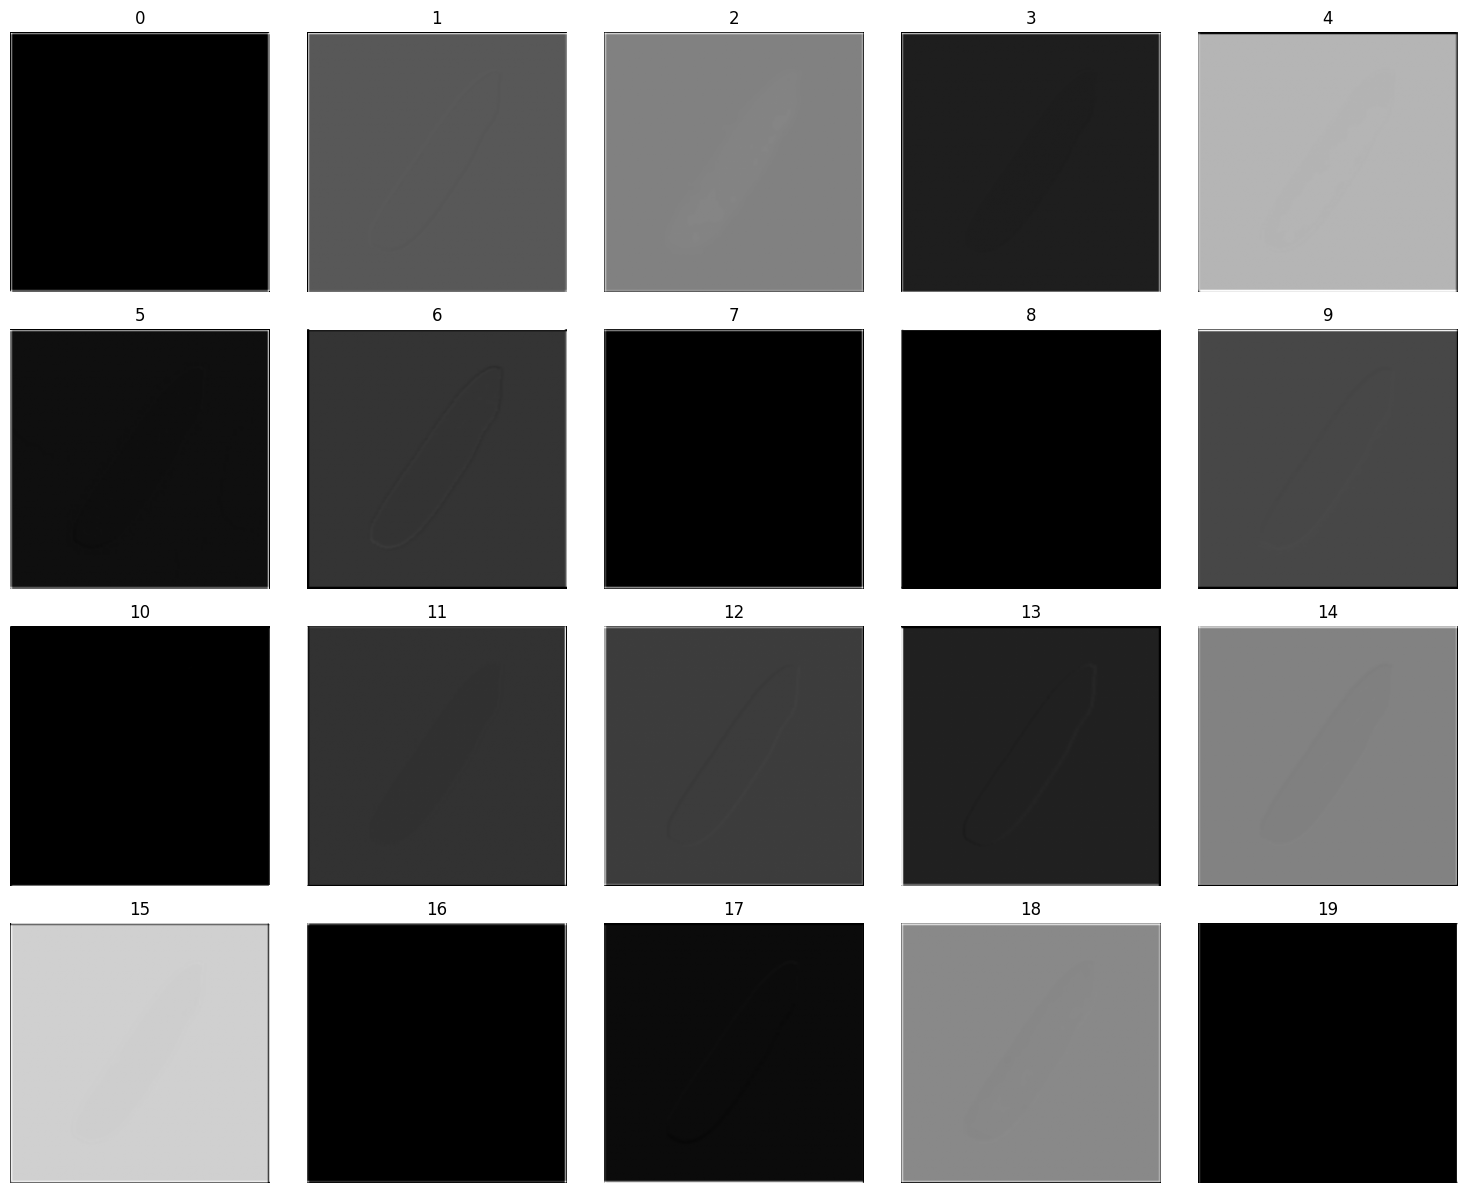

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


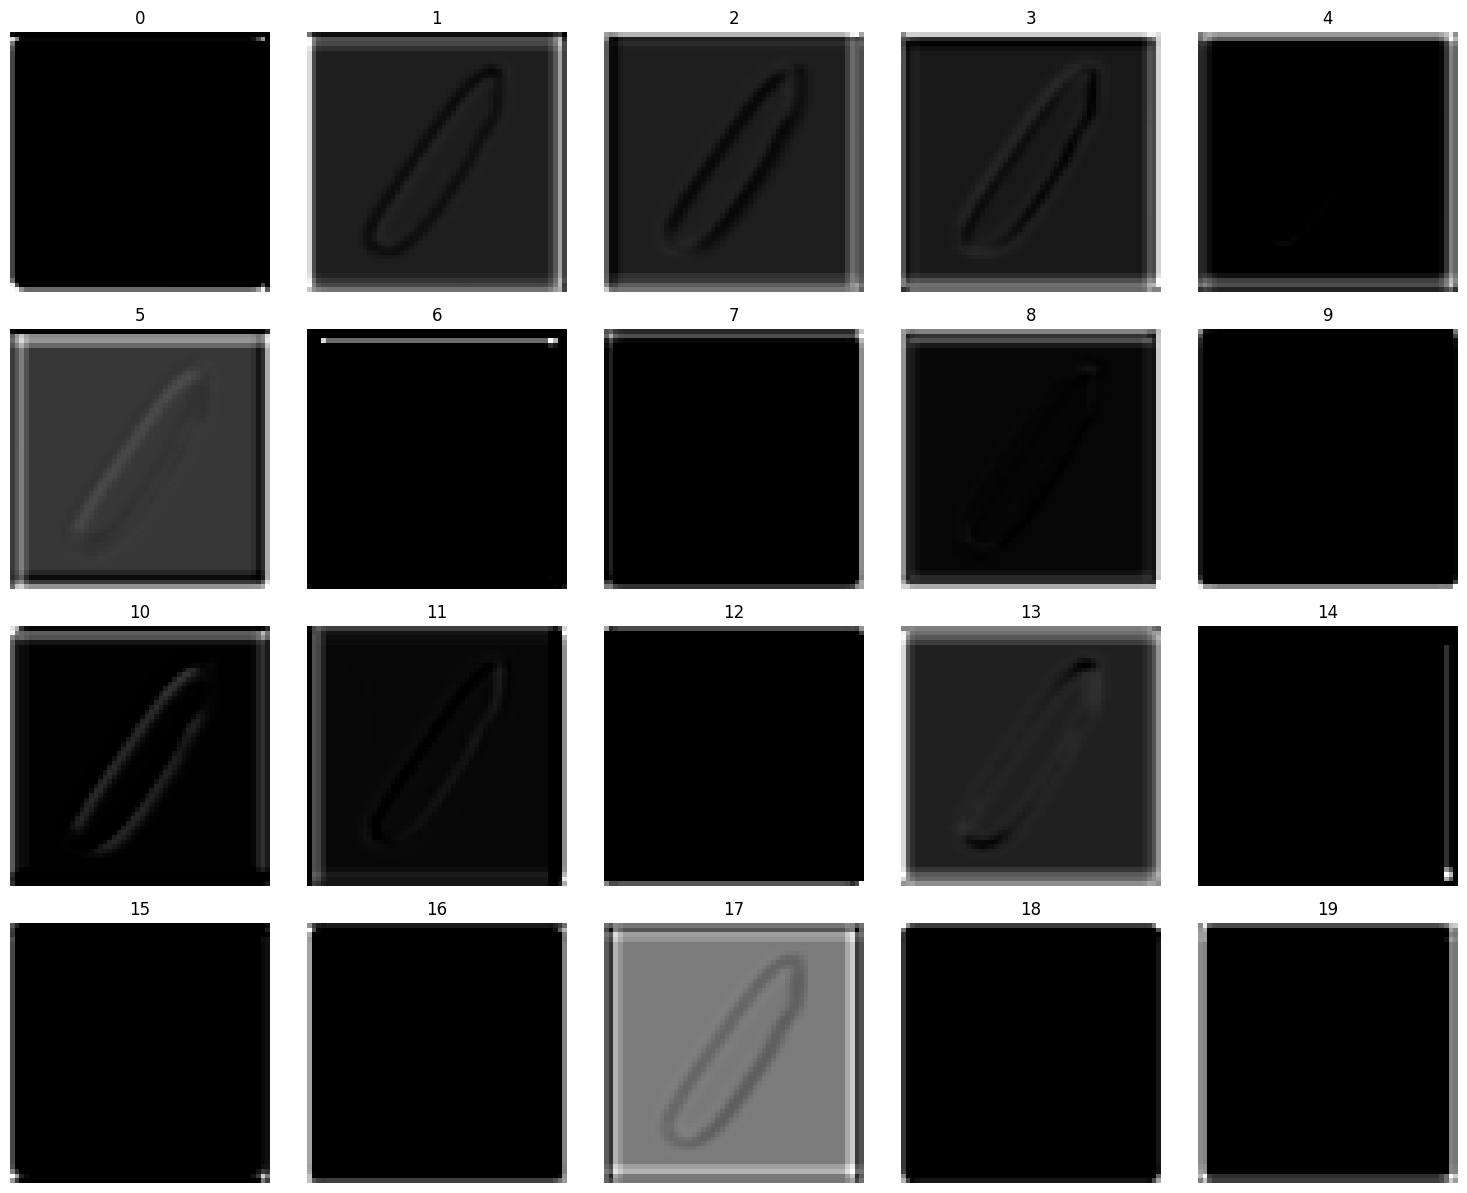

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


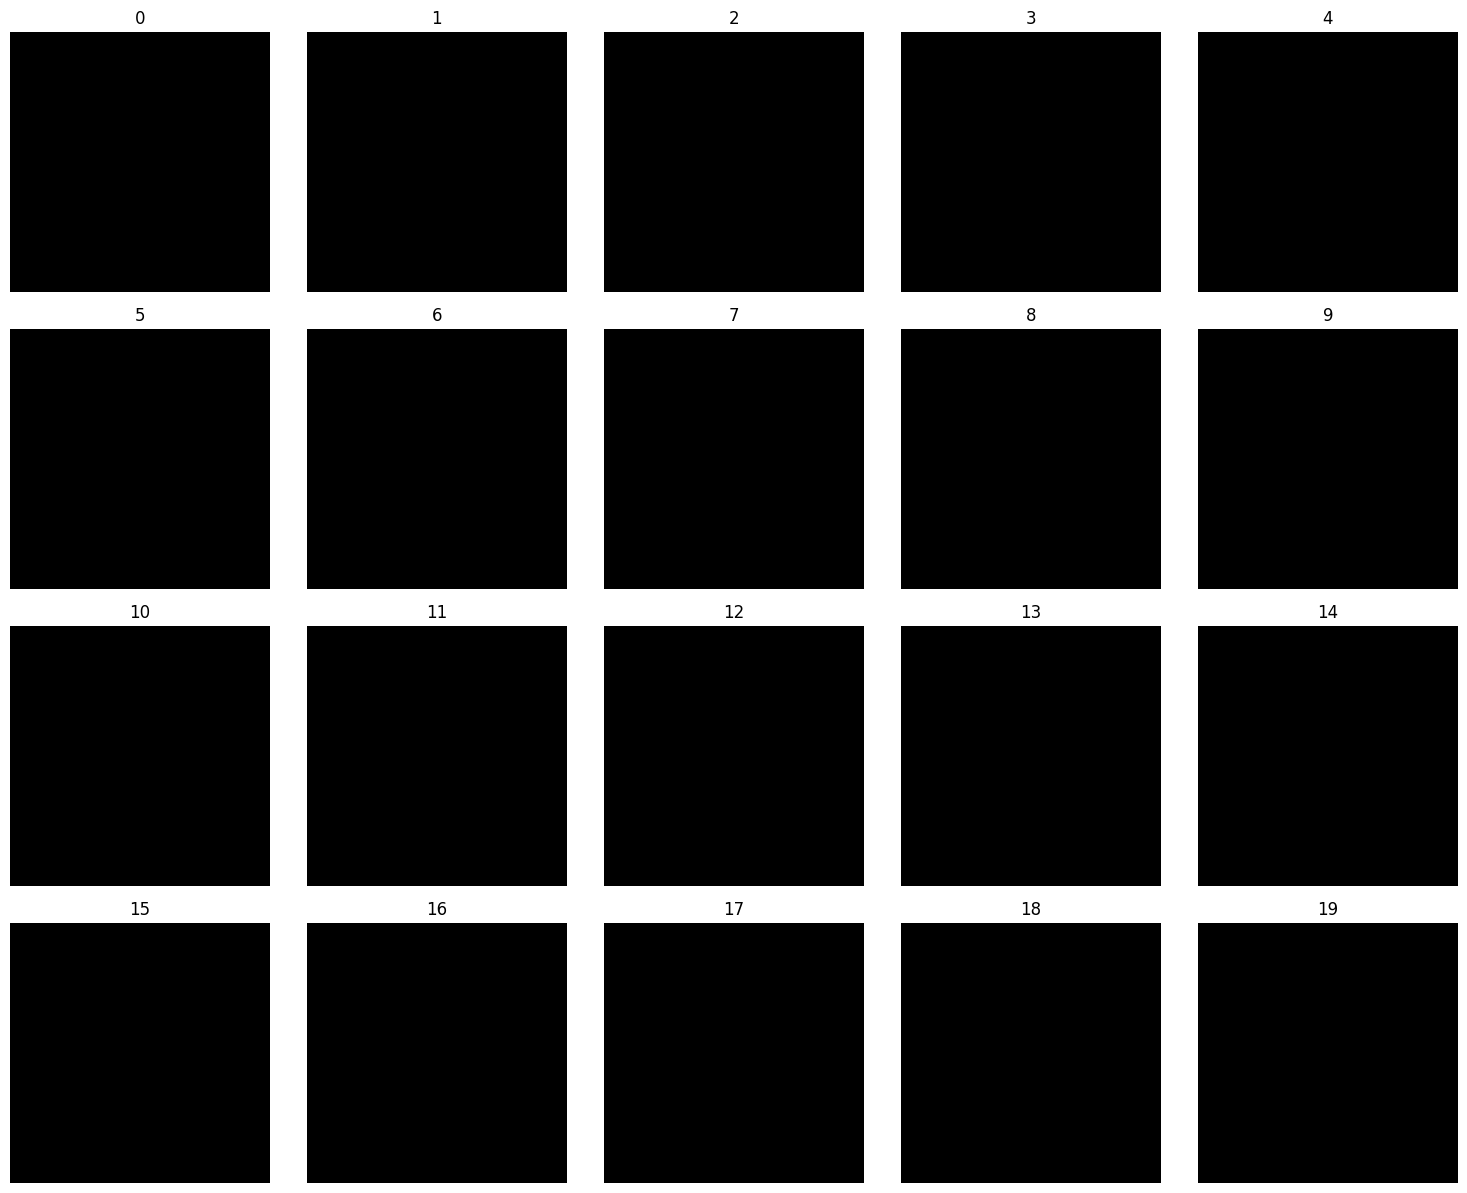

In [ ]:
# VGG Flatten Model
visualize_feature_maps(extract_feature_maps(VGG_Flatten, img_tensor, 1), 20)
visualize_feature_maps(extract_feature_maps(VGG_Flatten, img_tensor, 5), 20)
visualize_feature_maps(extract_feature_maps(VGG_Flatten, img_tensor, 12), 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


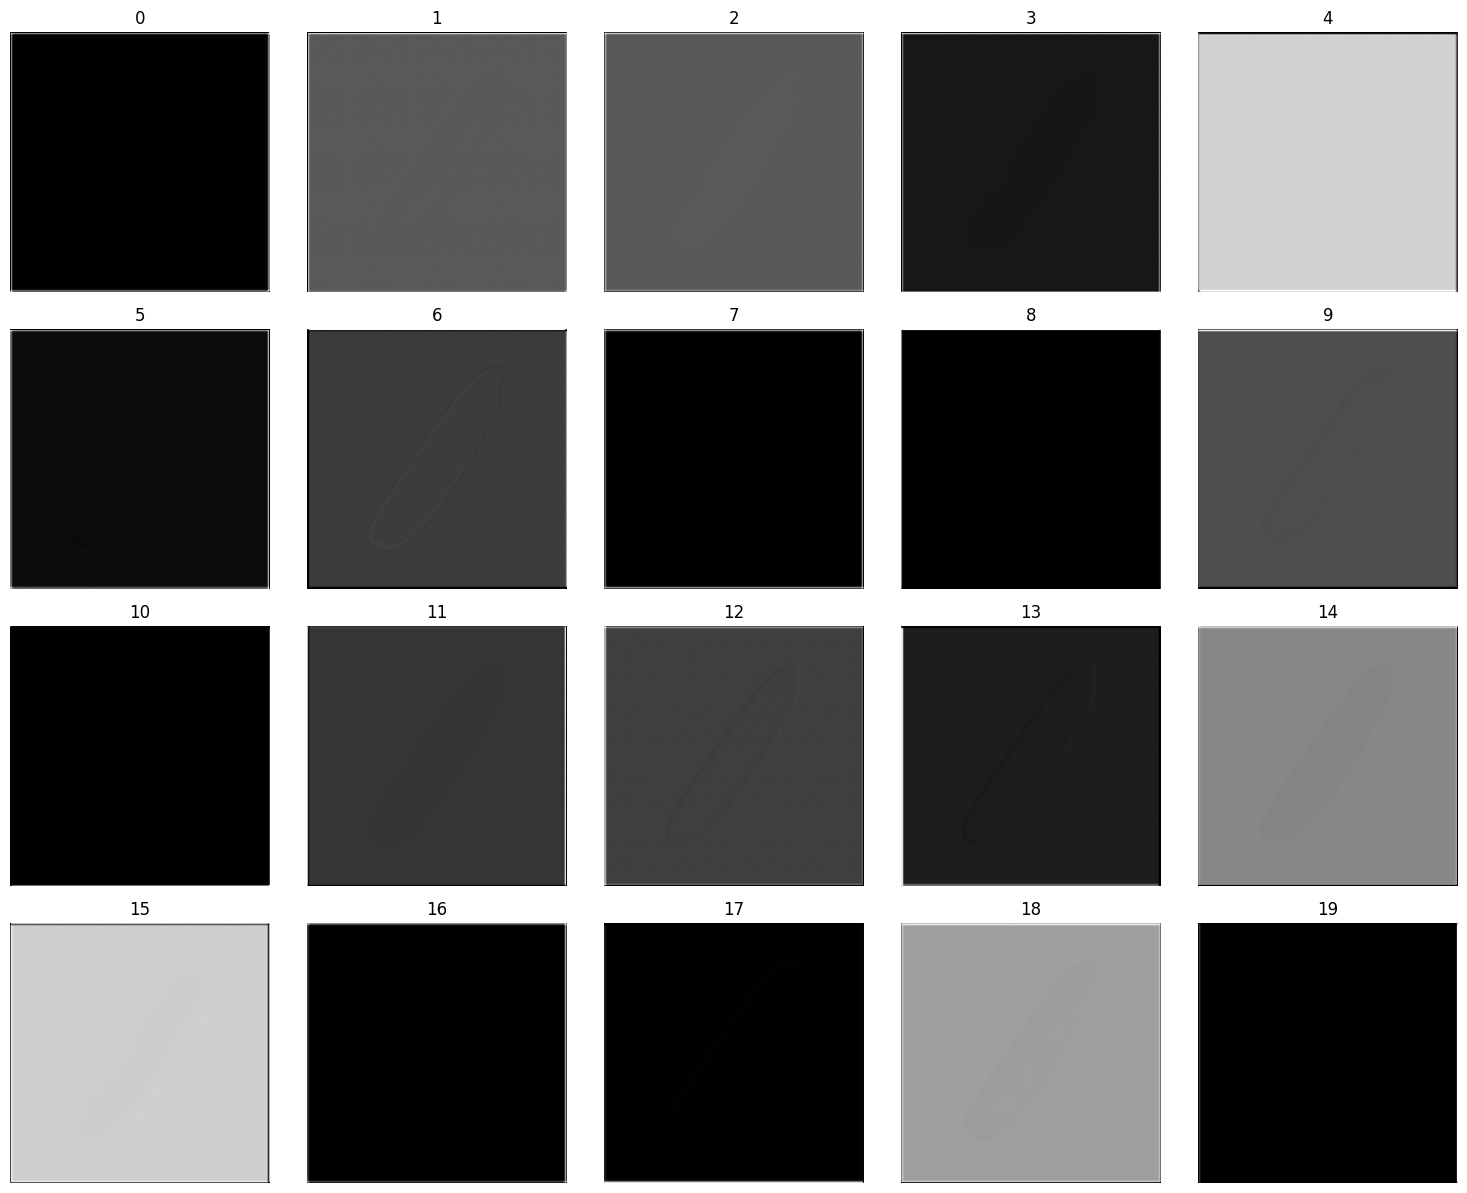

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


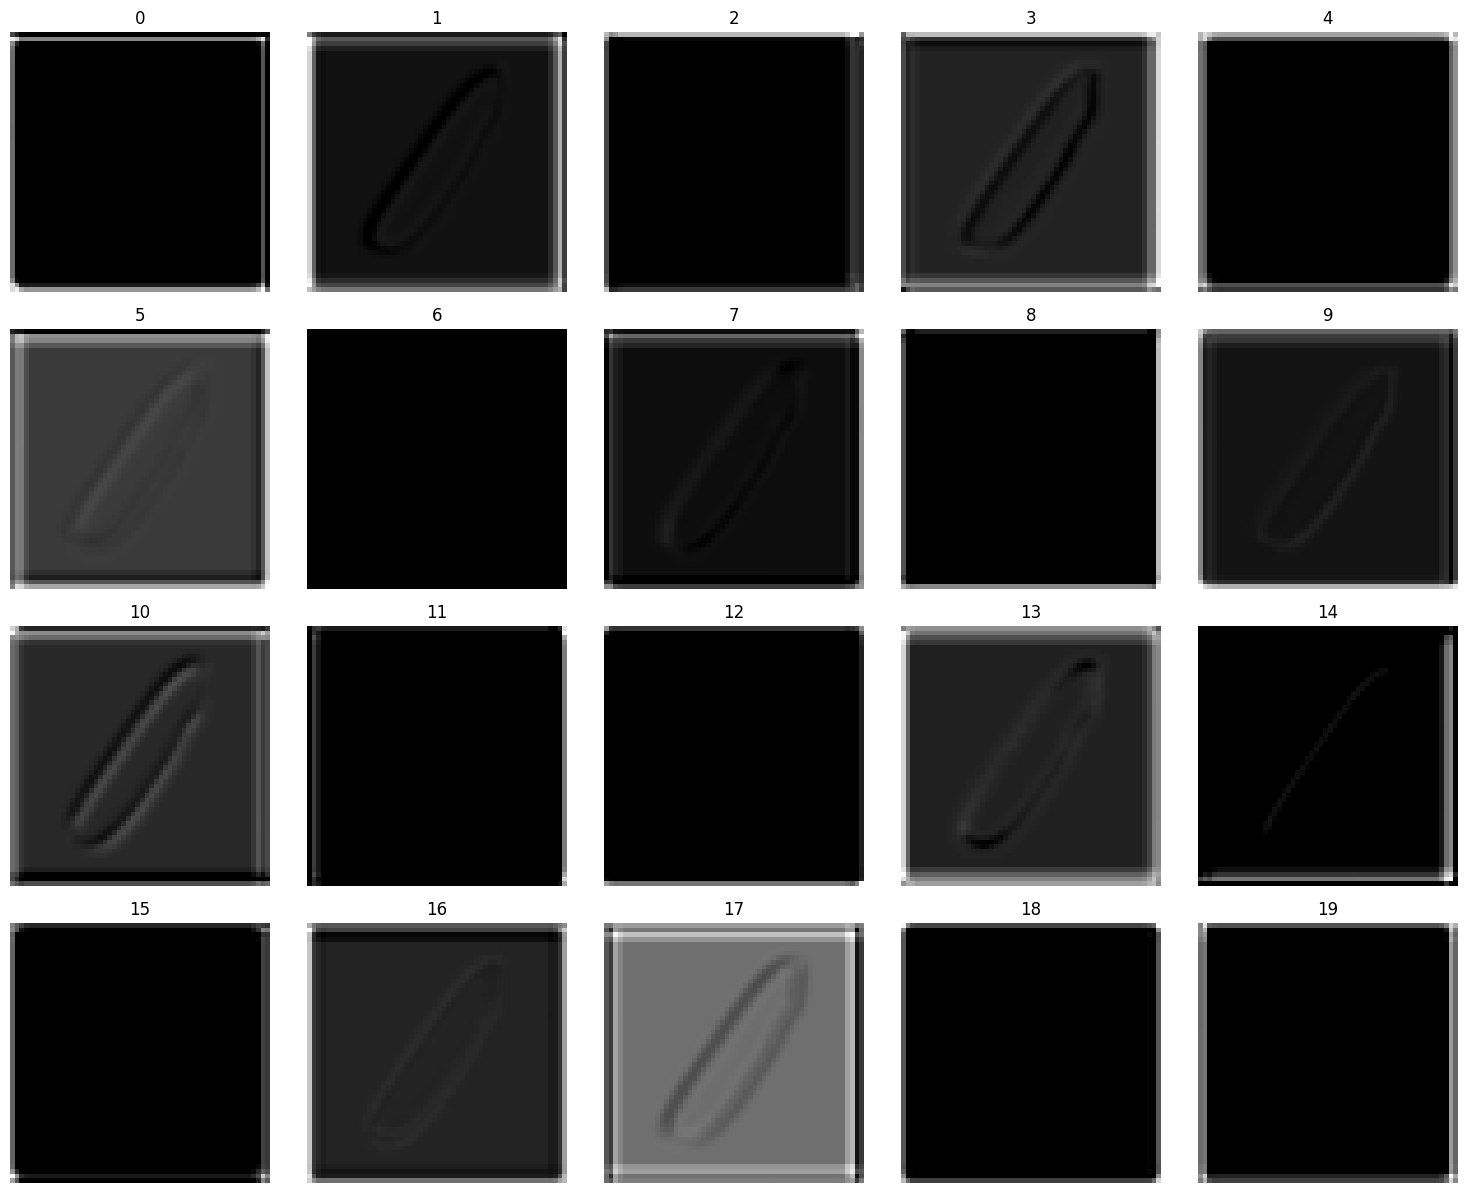

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


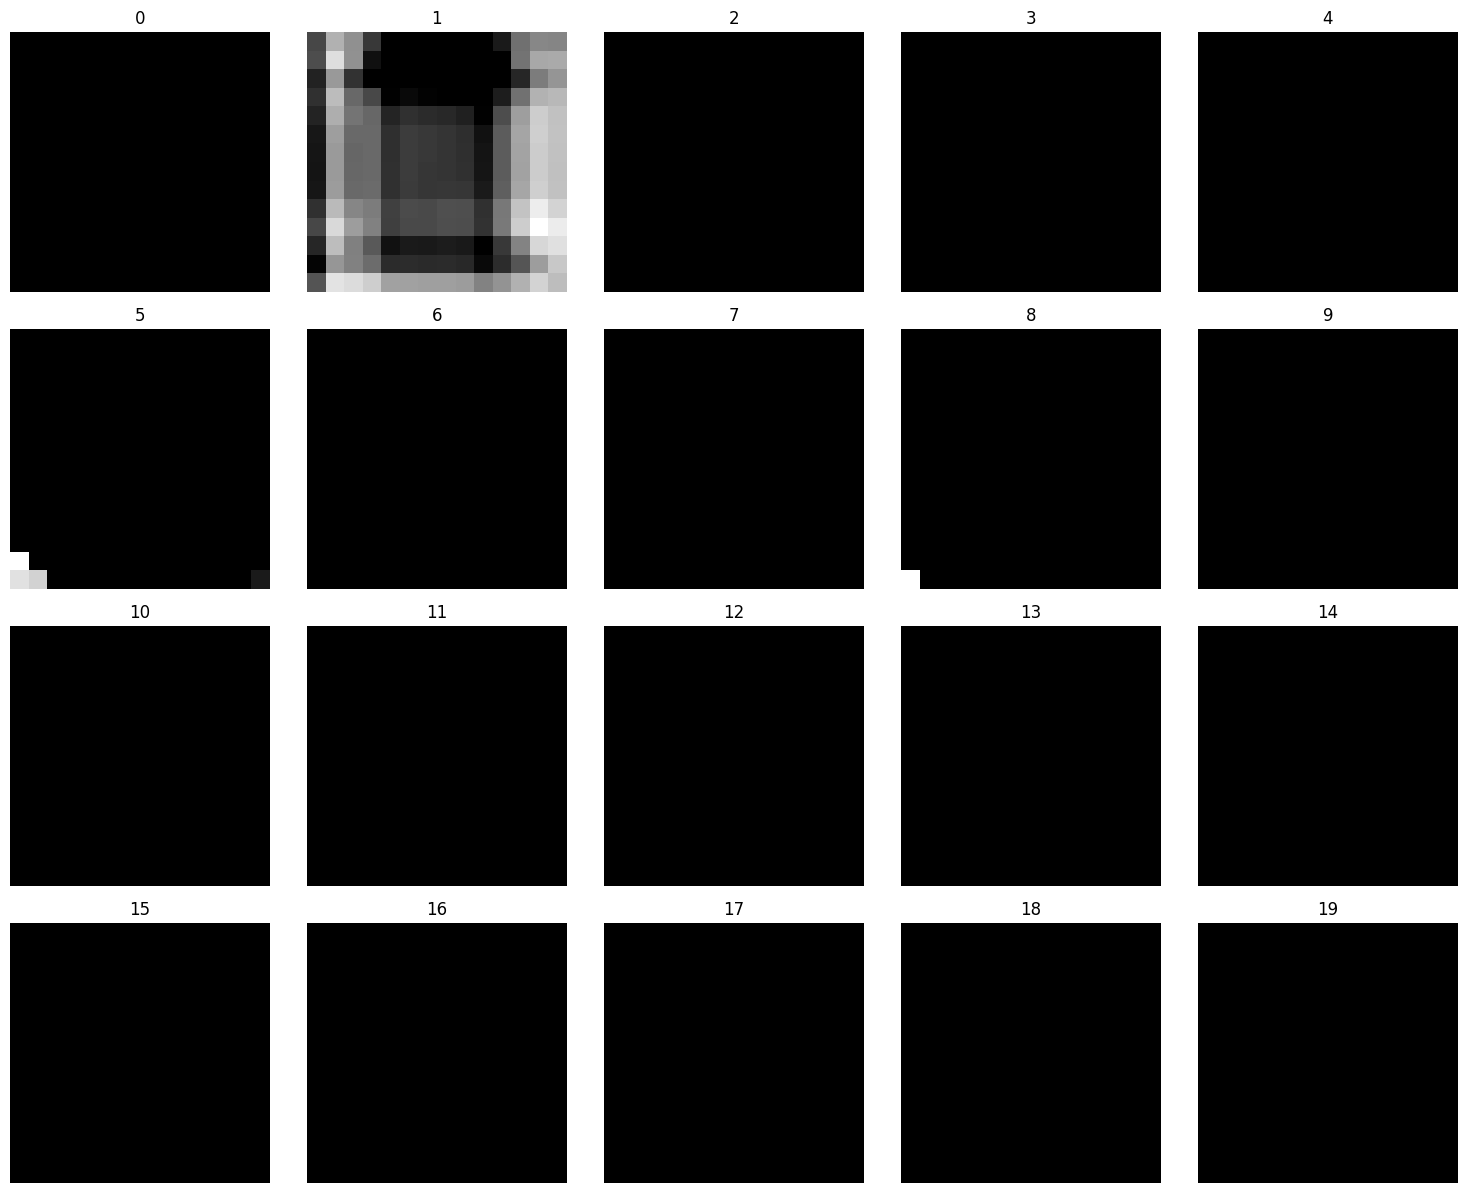

In [ ]:
# finetuned VGG Global Model
visualize_feature_maps(extract_feature_maps(finetuned_VGG_Global, img_tensor, 1), 20)
visualize_feature_maps(extract_feature_maps(finetuned_VGG_Global, img_tensor, 5), 20)
visualize_feature_maps(extract_feature_maps(finetuned_VGG_Global, img_tensor, 12), 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


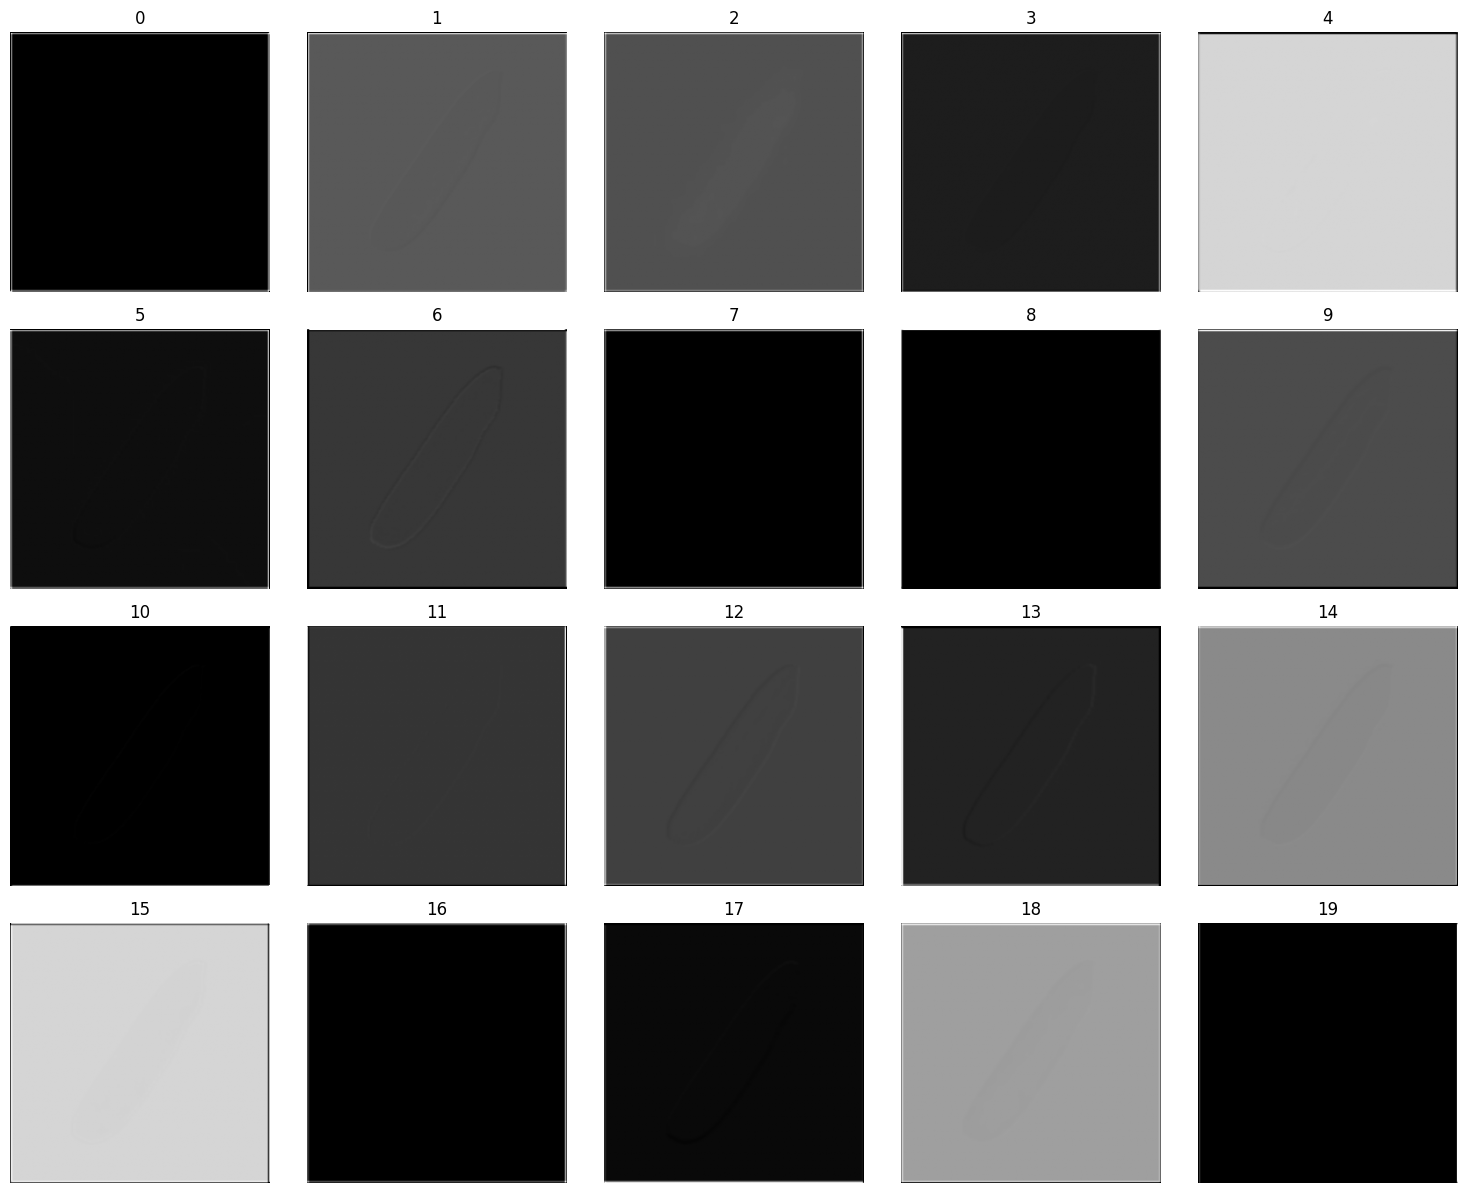

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


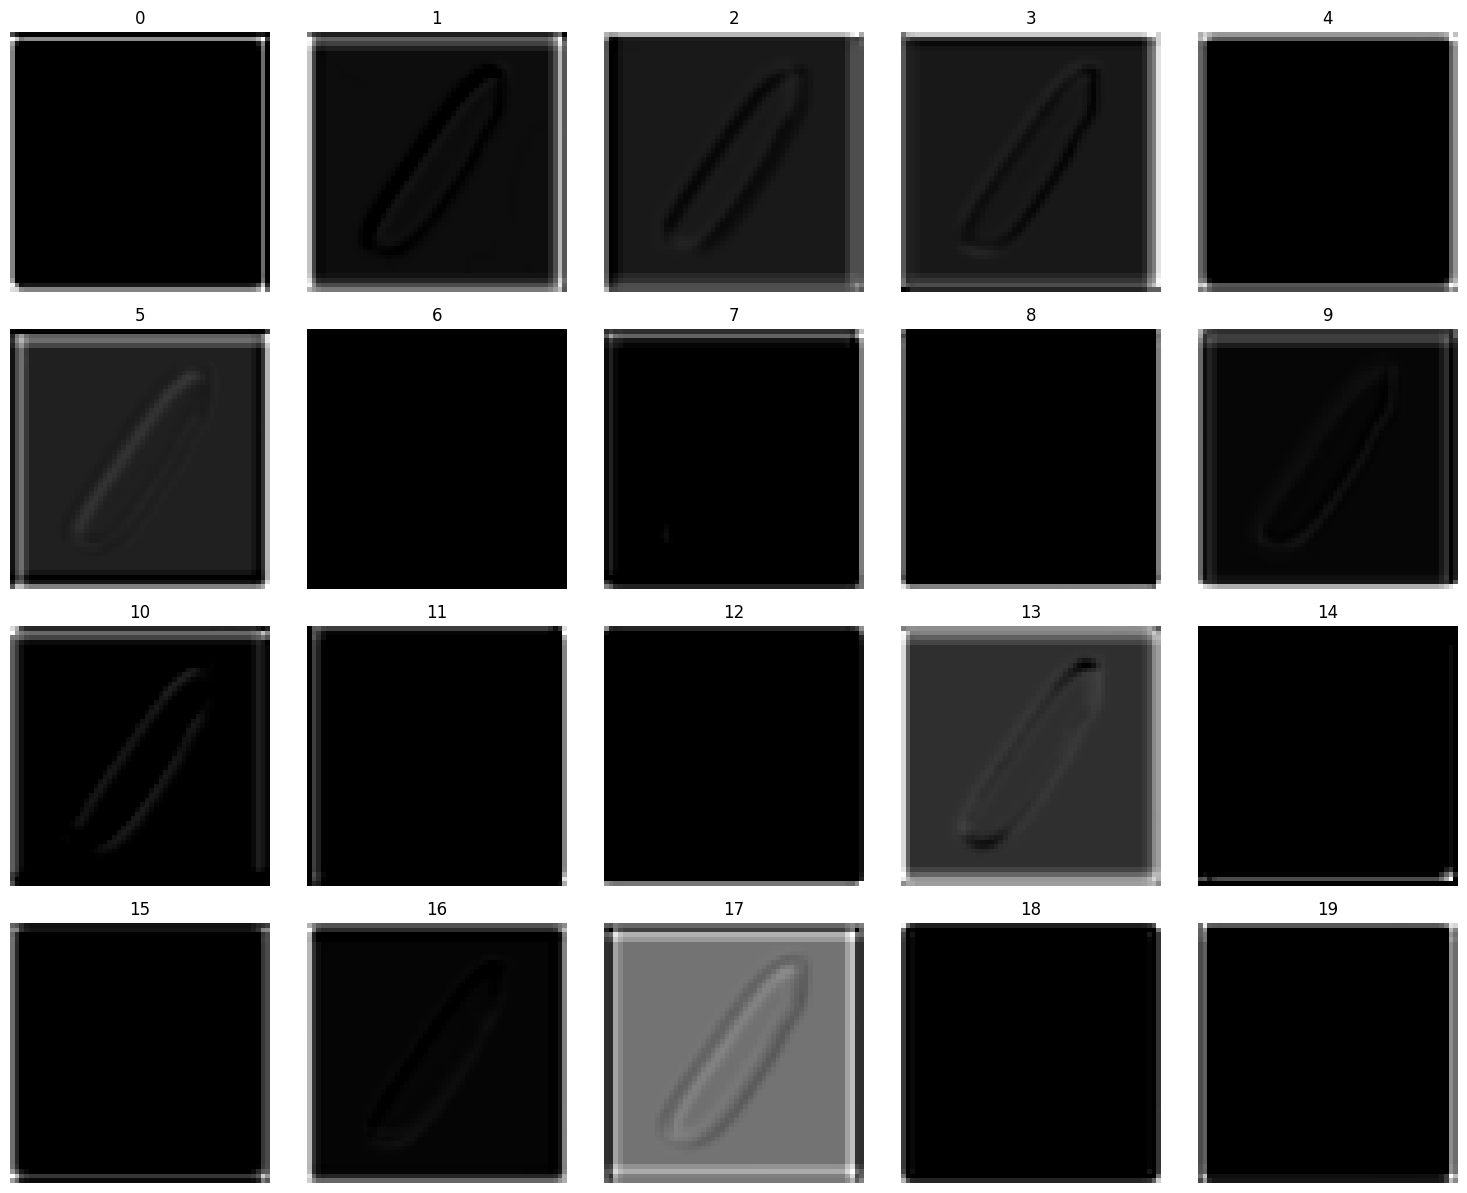

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step


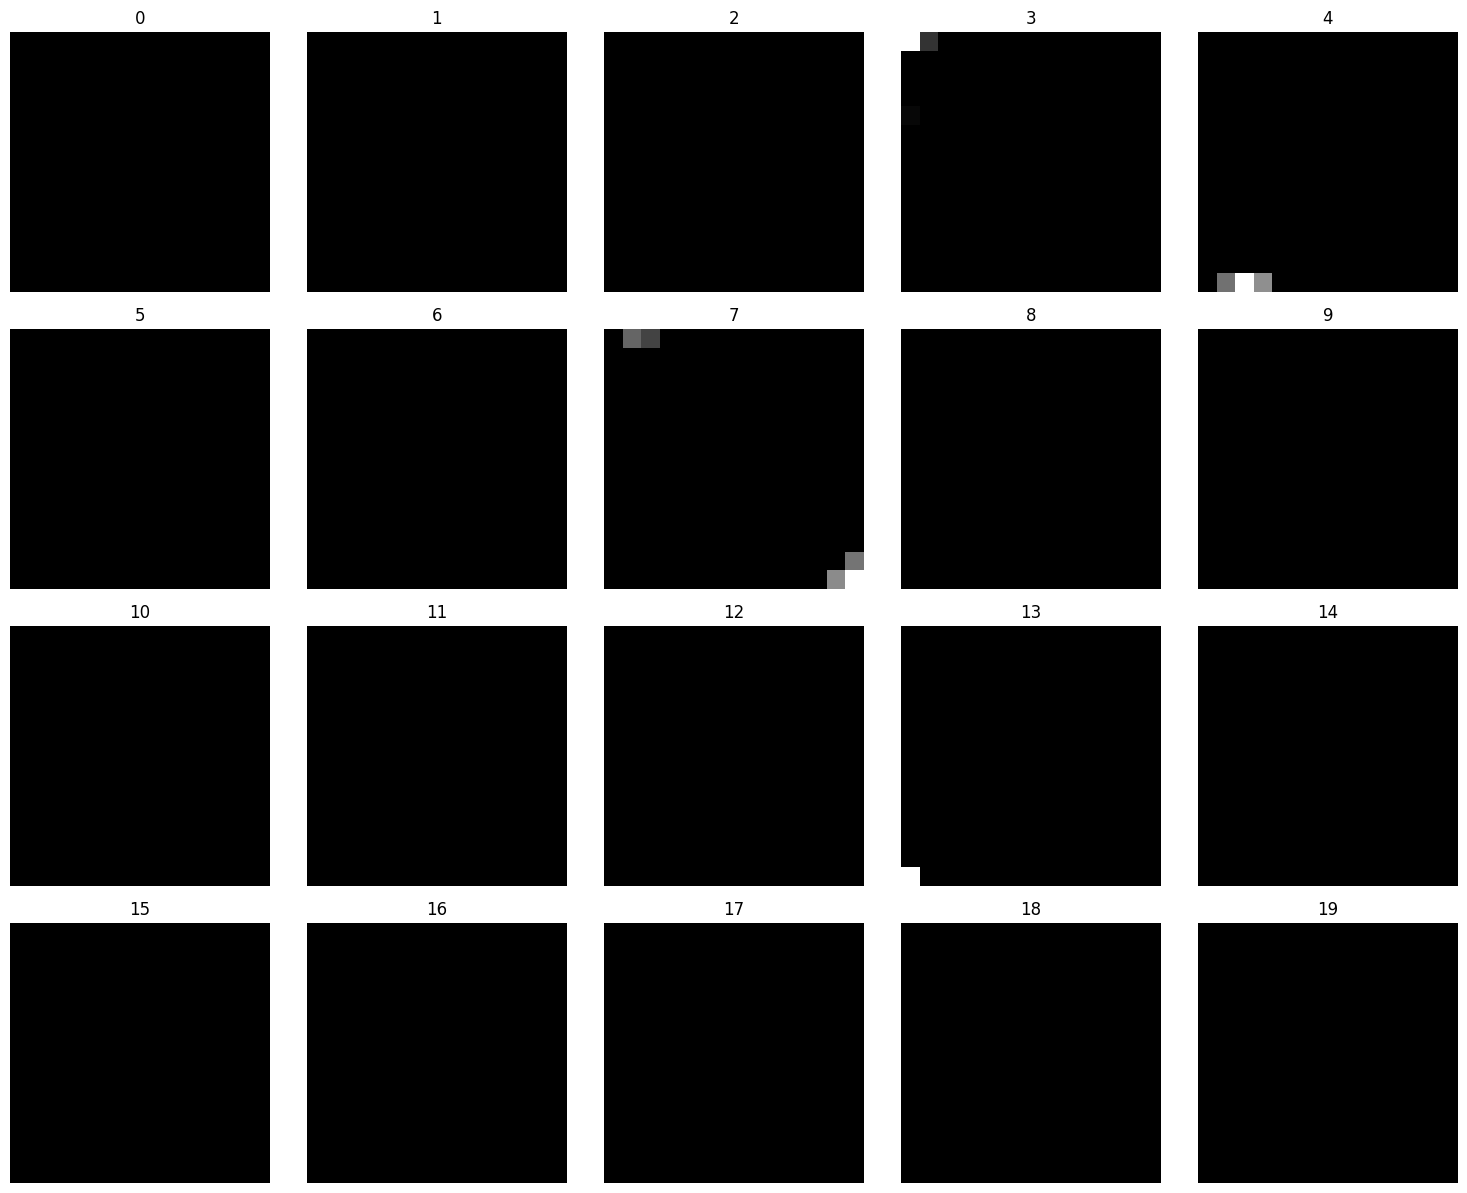

In [ ]:
# finetuned VGG Flatten Model
visualize_feature_maps(extract_feature_maps(finetuned_VGG_Flatten, img_tensor, 1), 20)
visualize_feature_maps(extract_feature_maps(finetuned_VGG_Flatten, img_tensor, 5), 20)
visualize_feature_maps(extract_feature_maps(finetuned_VGG_Flatten, img_tensor, 12), 20)

## Layer의 Filter간 Cosine Similarity 비교

In [ ]:
VGG_Global_CNN_Model = CNNModel(VGG_Global, include_top=True)
VGG_Global_CNN_Model

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

None

In [ ]:
VGG_Global_feature_layer = VGG_Global.layers[0]
VGG_Global_feature_layer.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Start!
------------row 0 start------------
col 0 done!
col 1 done!
col 2 done!
col 3 done!
col 4 done!
col 5 done!
col 6 done!
col 7 done!
col 8 done!
col 9 done!
col 10 done!
col 11 done!
col 12 done!
col 13 done!
col 14 done!
col 15 done!
col 16 done!
col 17 done!
col 18 done!
col 19 done!
col 20 done!
col 21 done!
col 22 done!
col 23 done!
col 24 done!
col 25 done!
col 26 done!
col 27 done!
col 28 done!
col 29 done!
col 30 done!
col 31 done!
col 32 done!
col 33 done!
col 34 done!
col 35 done!
col 36 done!
col 37 done!
col 38 done!
col 39 done!
col 40 done!
col 41 done!
col 42 done!
col 43 done!
col 44 done!
col 45 done!
col 46 done!
col 47 done!
col 48 done!
col 49 done!
col 50 done!
col 51 done!
col 52 done!
col 53 done!
col 54 done!
col 55 done!
col 56 done!
col 57 done!
col 58 done!
col 59 done!
col 60 done!
col 61 done!
col 62 done!
col 63 done!
------------row 1 start------------
col 1 done!
col 2 done!
col 3 done!
col 4 done!
col 5 done!
col 6 done!
col 7 done!
col 8 done!
col

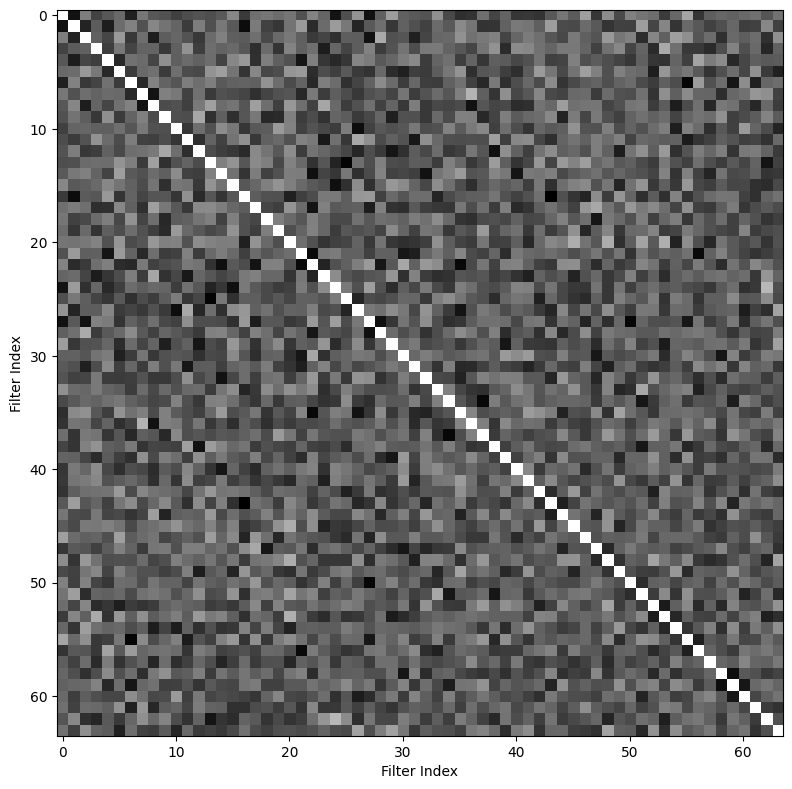

array([[ 1.        , -0.44845784,  0.21074378, ...,  0.12108356,
        -0.03897369,  0.13005167],
       [-0.44845784,  1.        , -0.34388542, ..., -0.16127932,
         0.26349258, -0.17133749],
       [ 0.21074378, -0.34388542,  1.        , ...,  0.10168713,
        -0.2577492 ,  0.31175911],
       ...,
       [ 0.12108356, -0.16127932,  0.10168713, ...,  1.        ,
        -0.20102847, -0.25672376],
       [-0.03897369,  0.26349258, -0.2577492 , ..., -0.20102847,
         1.        , -0.07040155],
       [ 0.13005167, -0.17133749,  0.31175911, ..., -0.25672376,
        -0.07040155,  1.        ]])

In [ ]:
# 밝을수록 유사.
VGG_Global_CNN_Model.conv_layers[0].show_filter_similarity()

In [ ]:
# 혹시나 0.95 이상 비슷한 필터가 있는지 확인해봅니다.
VGG_Global_CNN_Model.conv_layers[0].find_similar_filter_pair()

[]

Streaming output truncated to the last 5000 lines.
col 461 done!
col 462 done!
col 463 done!
col 464 done!
col 465 done!
col 466 done!
col 467 done!
col 468 done!
col 469 done!
col 470 done!
col 471 done!
col 472 done!
col 473 done!
col 474 done!
col 475 done!
col 476 done!
col 477 done!
col 478 done!
col 479 done!
col 480 done!
col 481 done!
col 482 done!
col 483 done!
col 484 done!
col 485 done!
col 486 done!
col 487 done!
col 488 done!
col 489 done!
col 490 done!
col 491 done!
col 492 done!
col 493 done!
col 494 done!
col 495 done!
col 496 done!
col 497 done!
col 498 done!
col 499 done!
col 500 done!
col 501 done!
col 502 done!
col 503 done!
col 504 done!
col 505 done!
col 506 done!
col 507 done!
col 508 done!
col 509 done!
col 510 done!
col 511 done!
------------row 414 start------------
col 414 done!
col 415 done!
col 416 done!
col 417 done!
col 418 done!
col 419 done!
col 420 done!
col 421 done!
col 422 done!
col 423 done!
col 424 done!
col 425 done!
col 426 done!
col 427 done!
c

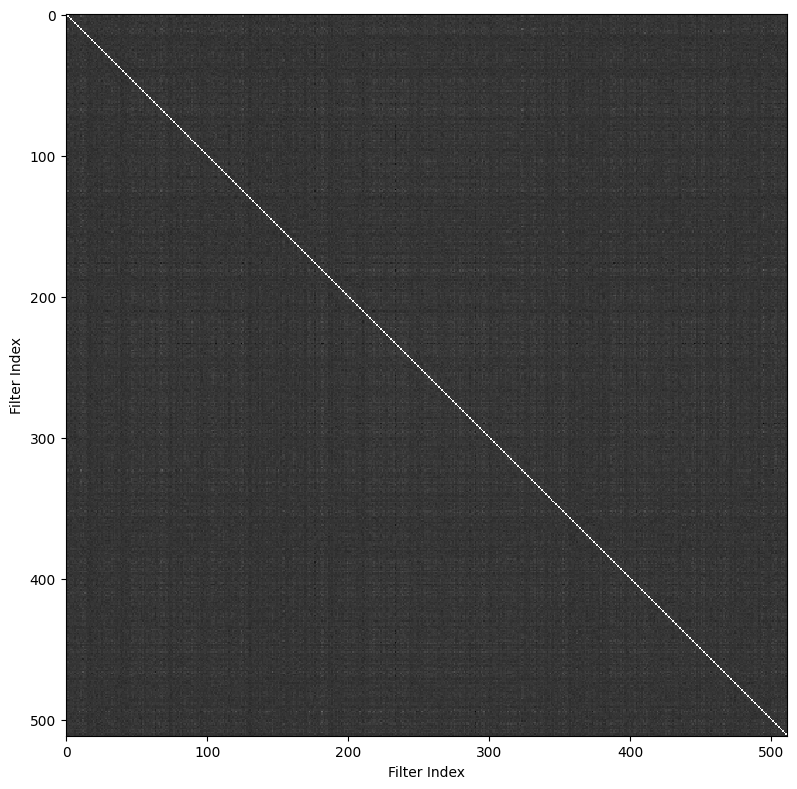

array([[ 1.        , -0.01165092, -0.00306475, ...,  0.02938318,
         0.00176358, -0.00611949],
       [-0.01165092,  1.        ,  0.01927423, ...,  0.03386164,
        -0.00766003, -0.03187656],
       [-0.00306475,  0.01927423,  1.        , ...,  0.01492733,
         0.0314821 , -0.02816856],
       ...,
       [ 0.02938318,  0.03386164,  0.01492733, ...,  1.        ,
        -0.00799119,  0.00371909],
       [ 0.00176358, -0.00766003,  0.0314821 , ..., -0.00799119,
         1.        , -0.00532687],
       [-0.00611949, -0.03187656, -0.02816856, ...,  0.00371909,
        -0.00532687,  1.        ]])

In [ ]:
VGG_Global_CNN_Model.conv_layers[-1].show_filter_similarity()

In [ ]:
# 여기도 유사한 필터는 없다...
len(VGG_Global_CNN_Model.conv_layers[-1].find_similar_filter_pair())

0

In [ ]:
# 유사한 전체 Filter 개수
VGG_Global_CNN_Model.count_similar_filter_pairs()

0

In [ ]:
# 각 layer 별 가장 유사한 필터쌍
VGG_Global_CNN_Model.find_most_similar_filter_pairs()

[(24, 62, np.float32(0.5606682)),
 (13, 31, np.float32(0.3075992)),
 (62, 68, np.float32(0.52251965)),
 (2, 13, np.float32(0.22086912)),
 (34, 36, np.float32(0.34690166)),
 (46, 114, np.float32(0.2661692)),
 (209, 223, np.float32(0.18418759)),
 (232, 266, np.float32(0.2785892)),
 (231, 349, np.float32(0.17973381)),
 (386, 507, np.float32(0.25793177)),
 (291, 469, np.float32(0.13514447)),
 (2, 161, np.float32(0.21175086)),
 (181, 494, np.float32(0.2788564))]

In [ ]:
finetuned_VGG_Global_CNN_Model = CNNModel(finetuned_VGG_Global, include_top=True)
finetuned_VGG_Global_CNN_Model

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_29 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

None

In [ ]:
finetuned_VGG_Global_CNN_Model.conv_layers

[<Conv2D name=block1_conv1, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <Conv2D name=block2_conv1, built=True>,
 <Conv2D name=block2_conv2, built=True>,
 <Conv2D name=block3_conv1, built=True>,
 <Conv2D name=block3_conv2, built=True>,
 <Conv2D name=block3_conv3, built=True>,
 <Conv2D name=block4_conv1, built=True>,
 <Conv2D name=block4_conv2, built=True>,
 <Conv2D name=block4_conv3, built=True>,
 <Conv2D name=block5_conv1, built=True>,
 <Conv2D name=block5_conv2, built=True>,
 <Conv2D name=block5_conv3, built=True>]

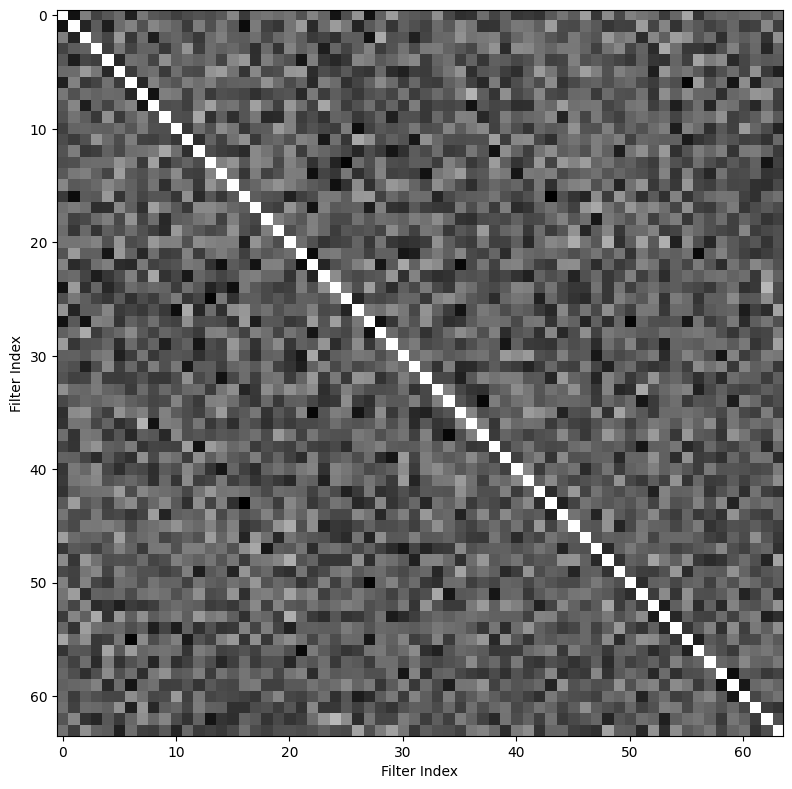

array([[ 1.        , -0.44792318,  0.20865464, ...,  0.12206584,
        -0.03978205,  0.12777203],
       [-0.44792318,  1.        , -0.33770311, ..., -0.16166365,
         0.2635324 , -0.17476749],
       [ 0.20865464, -0.33770311,  1.        , ...,  0.10185432,
        -0.2578218 ,  0.31674862],
       ...,
       [ 0.12206584, -0.16166365,  0.10185432, ...,  1.        ,
        -0.201612  , -0.25417495],
       [-0.03978205,  0.2635324 , -0.2578218 , ..., -0.201612  ,
         1.        , -0.07337785],
       [ 0.12777203, -0.17476749,  0.31674862, ..., -0.25417495,
        -0.07337785,  1.        ]])

In [ ]:
finetuned_VGG_Global_CNN_Model.conv_layers[0].show_filter_similarity()

In [ ]:
len(finetuned_VGG_Global_CNN_Model.conv_layers[0].find_similar_filter_pair())

0

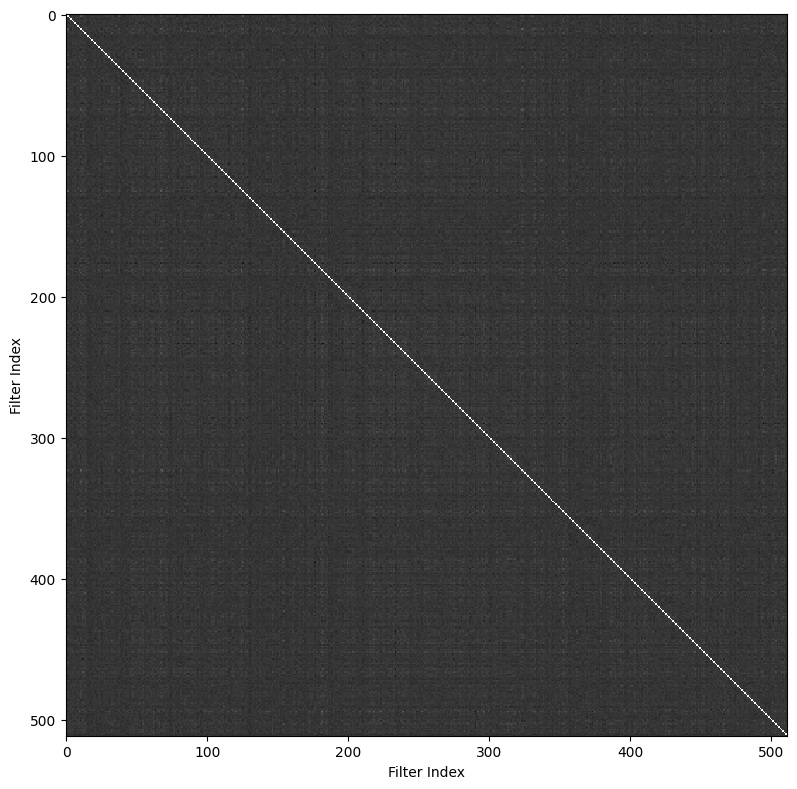

array([[ 1.        , -0.01656413,  0.00109208, ...,  0.02657664,
         0.00191587, -0.00622129],
       [-0.01656413,  1.        ,  0.01903832, ...,  0.0390842 ,
        -0.01264393, -0.03027236],
       [ 0.00109208,  0.01903832,  1.        , ...,  0.01251441,
         0.03623605, -0.0170877 ],
       ...,
       [ 0.02657664,  0.0390842 ,  0.01251441, ...,  1.        ,
        -0.00257683,  0.01036674],
       [ 0.00191587, -0.01264393,  0.03623605, ..., -0.00257683,
         1.        , -0.00454545],
       [-0.00622129, -0.03027236, -0.0170877 , ...,  0.01036674,
        -0.00454545,  1.        ]])

In [ ]:
finetuned_VGG_Global_CNN_Model.conv_layers[-1].show_filter_similarity()

In [ ]:
len(finetuned_VGG_Global_CNN_Model.conv_layers[-1].find_similar_filter_pair())

0

In [ ]:
finetuned_VGG_Global_CNN_Model.count_similar_filter_pairs()

0

In [ ]:
finetuned_VGG_Global_CNN_Model.find_most_similar_filter_pairs()

[(24, 62, np.float32(0.5618686)),
 (13, 31, np.float32(0.31168485)),
 (62, 68, np.float32(0.5208788)),
 (59, 70, np.float32(0.21815073)),
 (34, 36, np.float32(0.34609008)),
 (46, 114, np.float32(0.2628237)),
 (125, 138, np.float32(0.18586439)),
 (232, 266, np.float32(0.28087395)),
 (231, 349, np.float32(0.19171202)),
 (38, 138, np.float32(0.2531333)),
 (469, 501, np.float32(0.1394161)),
 (2, 161, np.float32(0.20543528)),
 (181, 494, np.float32(0.27741855))]

## L1-Norm Pruning
- 필터의 절댓값 합을 기준으로 중요하지 않은 필터를 걸러내는 방식

### 10% Pruning, Classification Layer는 그대로 사용

In [ ]:
new_base_model = VGG_Global_CNN_Model.build_l1_norm_pruned_model(include_top=True)
x = new_base_model.output
for layer in VGG_Global.layers[1:]:
    x = layer(x)
pruned_10_include_top_VGG_Global= Model(inputs=new_base_model.input, outputs=x)
adam = Adam(learning_rate=0.001)
pruned_10_include_top_VGG_Global.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
os.makedirs(os.path.join(DRIVE_PATH, 'model'), exist_ok=True)
pruned_10_include_top_VGG_Global.save(os.path.join(DRIVE_PATH, 'model', f'pruned_10_include_top_VGG_Global.keras'))
loss, accuracy = pruned_10_include_top_VGG_Global.evaluate(test_data)
loss, accuracy

704/704 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.3585 - loss: 21.3881


(21.4581241607666, 0.35893332958221436)

### 5% Pruning, Classification Layer는 그대로 사용

In [ ]:
new_base_model = VGG_Global_CNN_Model.build_l1_norm_pruned_model(include_top=True, percentage=0.05)
x = new_base_model.output
for layer in VGG_Global.layers[1:]:
    x = layer(x)
pruned_5_include_top_VGG_Global= Model(inputs=new_base_model.input, outputs=x)
adam = Adam(learning_rate=0.001)
pruned_5_include_top_VGG_Global.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
os.makedirs(os.path.join(DRIVE_PATH, 'model'), exist_ok=True)
pruned_5_include_top_VGG_Global.save(os.path.join(DRIVE_PATH, 'model', f'pruned_10_include_top_VGG_Global.keras'))
loss, accuracy = pruned_5_include_top_VGG_Global.evaluate(test_data)
loss, accuracy

704/704 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5906 - loss: 4.9468


(4.9913811683654785, 0.5864889025688171)

### 10% Pruning, Classification Layer 학습

In [ ]:
new_base_model = VGG_Global_CNN_Model.build_l1_norm_pruned_model(include_top=True)
x = new_base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
pruned_10_VGG_Global= Model(inputs=new_base_model.input, outputs=x)
adam = Adam(learning_rate=0.001)
pruned_10_VGG_Global.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_pruned_10_VGG_Global.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
pruned_10_VGG_Global_history = pruned_10_VGG_Global.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 65s 17ms/step - accuracy: 0.6884 - loss: 0.8197 - val_accuracy: 0.9474 - val_loss: 0.1778 - learning_rate: 0.0010
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.9271 - loss: 0.2114 - val_accuracy: 0.9735 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.9479 - loss: 0.1556 - val_accuracy: 0.9705 - val_loss: 0.1018 - learning_rate: 0.0010
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.9542 - loss: 0.1331 - val_accuracy: 0.9758 - val_loss: 0.0778 - learning_rate: 0.0010
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9565 - loss: 0.1279 - val_accuracy: 0.9762 - val_loss: 0.0768 - learning_rate: 0.0010
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.9608 - loss: 0.1141 - val_accuracy: 0.9616 - val_loss: 0.0955 - learning_rate: 0.0010
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accura

In [ ]:
after_train(pruned_10_VGG_Global, 'pruned_10_VGG_Global', pruned_10_VGG_Global_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.9889 - loss: 0.0397


(0.03755838796496391, 0.9891555309295654)

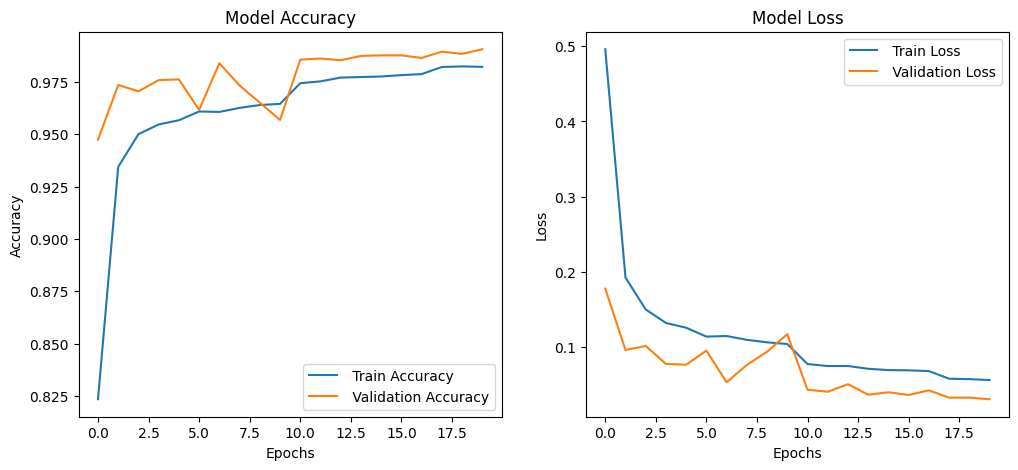

In [ ]:
visualize_history(pruned_10_VGG_Global_history)

### 5% Pruning, Classification Layer 학습

In [ ]:
new_base_model = VGG_Global_CNN_Model.build_l1_norm_pruned_model(include_top=True, percentage=0.05)
x = new_base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
pruned_5_VGG_Global= Model(inputs=new_base_model.input, outputs=x)
adam = Adam(learning_rate=0.001)
pruned_5_VGG_Global.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_pruned_5_VGG_Global.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
pruned_5_VGG_Global_history = pruned_5_VGG_Global.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 58s 16ms/step - accuracy: 0.7834 - loss: 0.6089 - val_accuracy: 0.9709 - val_loss: 0.0962 - learning_rate: 0.0010
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9544 - loss: 0.1363 - val_accuracy: 0.9795 - val_loss: 0.0723 - learning_rate: 0.0010
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9659 - loss: 0.1026 - val_accuracy: 0.9790 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9673 - loss: 0.0995 - val_accuracy: 0.9836 - val_loss: 0.0527 - learning_rate: 0.0010
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9688 - loss: 0.0905 - val_accuracy: 0.9844 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 50s 15ms/step - accuracy: 0.9726 - loss: 0.0847 - val_accuracy: 0.9837 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step - accura

In [ ]:
after_train(pruned_5_VGG_Global, 'pruned_5_VGG_Global', pruned_5_VGG_Global_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9884 - loss: 0.0361


(0.03724775090813637, 0.9879111051559448)

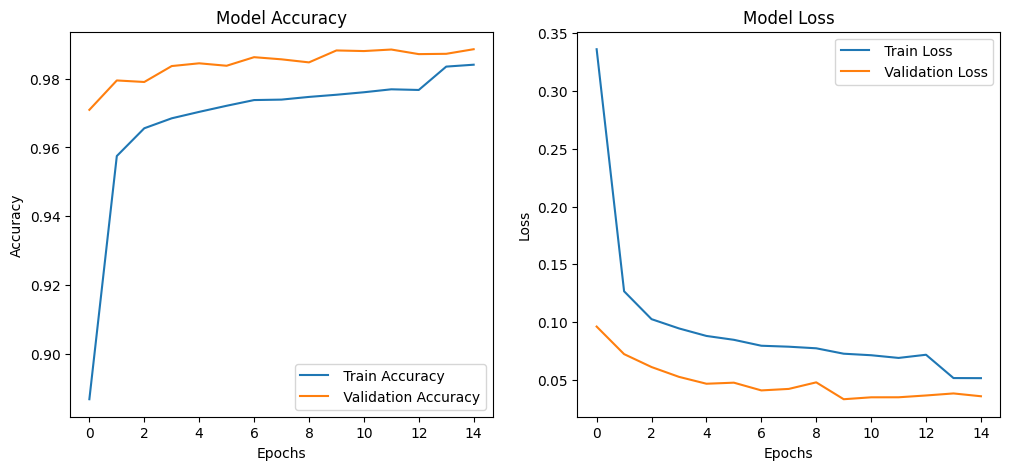

In [ ]:
visualize_history(pruned_5_VGG_Global_history)

### 20% Pruning, Classification Layer 학습

In [ ]:
new_base_model = VGG_Global_CNN_Model.build_l1_norm_pruned_model(include_top=True, percentage=0.2)
x = new_base_model.output
x = GlobalAvgPool2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(5, activation='softmax')(x)
pruned_20_VGG_Global= Model(inputs=new_base_model.input, outputs=x)
adam = Adam(learning_rate=0.001)
pruned_20_VGG_Global.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_pruned_20_VGG_Global.weights.h5', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
time_callback = TimeHistory()
pruned_20_VGG_Global_history = pruned_20_VGG_Global.fit(train_data, verbose=1, epochs=20, validation_data=val_data, callbacks=[early_stopping, reduce_lr, checkpoint, time_callback])

Epoch 1/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 52s 15ms/step - accuracy: 0.5360 - loss: 1.1697 - val_accuracy: 0.9179 - val_loss: 0.2984 - learning_rate: 0.0010
Epoch 2/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.8654 - loss: 0.3921 - val_accuracy: 0.9370 - val_loss: 0.1997 - learning_rate: 0.0010
Epoch 3/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 45s 14ms/step - accuracy: 0.8958 - loss: 0.2972 - val_accuracy: 0.9573 - val_loss: 0.1554 - learning_rate: 0.0010
Epoch 4/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9093 - loss: 0.2560 - val_accuracy: 0.9472 - val_loss: 0.1448 - learning_rate: 0.0010
Epoch 5/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9140 - loss: 0.2356 - val_accuracy: 0.9572 - val_loss: 0.1246 - learning_rate: 0.0010
Epoch 6/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9234 - loss: 0.2168 - val_accuracy: 0.9731 - val_loss: 0.0882 - learning_rate: 0.0010
Epoch 7/20
3282/3282 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accura

In [ ]:
after_train(pruned_20_VGG_Global, 'pruned_20_VGG_Global', pruned_20_VGG_Global_history, time_callback)

704/704 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9868 - loss: 0.0389


(0.04168079420924187, 0.9860444664955139)

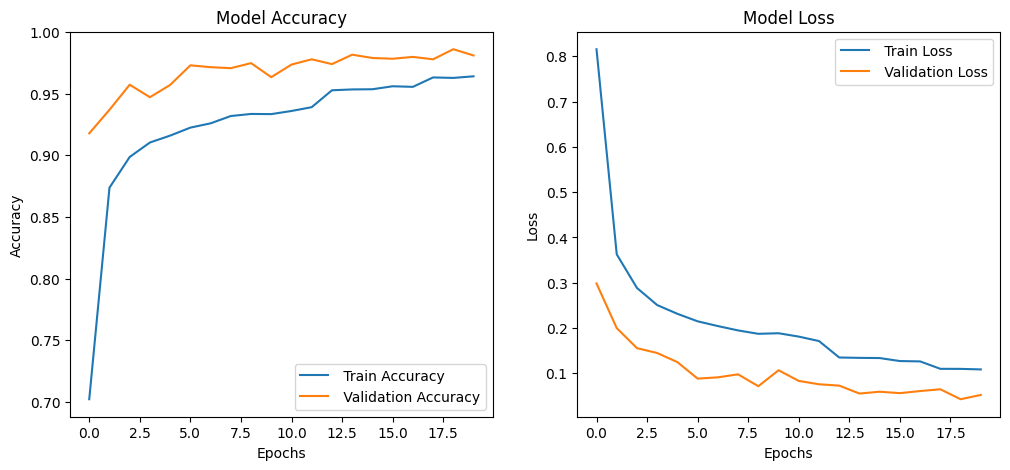

In [ ]:
visualize_history(pruned_20_VGG_Global_history)